In [1]:
#Criado por: Vinícius de Almeida Nery Ferreira (ECO - UnB)
#Github: https://github.com/vnery5/Econometria

#######################################################################################################################
###COMO USAR AS FUNÇÕES EM UM NOTEBOOK
##Antes, copie e cole todos os imports e definições daqui na primeira célula do notebook e pressione Shift + Enter
##Para coletar os dados do arquivo "carros.dta" (só funciona com arquivos .dta):
#coletar_dados("carros")

## Exportar resultados como imagem ou texto: https://stackoverflow.com/questions/46664082/python-how-to-save-statsmodels-results-as-image-file
#######################################################################################################################

##Importando os pacotes e módulos necessários
import pandas as pd
import numpy as np
import math

#Para Regressão Linear Simples e Teste F
from scipy import stats

#Para Regressão Linear Múltipla (OLS, GLS e WLS) e Testes Estatísticos
import statsmodels.api as sm
import econtools
import econtools.metrics as mt

#Para Regressão em Painel e IV
from linearmodels import PanelOLS, FirstDifferenceOLS, PooledOLS, RandomEffects
from linearmodels.panel import compare
from linearmodels.iv import IV2SLS

#Pacotes para gráficos (caso precise)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#Pacotes para fazer a coleta dos dados armazenados no mesmo diretório e outros pacotes gerais
import os
import pathlib
import glob
from IPython.display import clear_output
import gc
import subprocess #permite a cópia para o clipboard das equações gerados com as funções equation()

####################################### Criando as Funções ###############################################################

def coletar_dados(nome = ""):
    '''
    Função que le os arquivos do Stata (.dta) - NÃO COLOQUE A EXTENSÃO NA HORA DE NOMEAR O "NOME"!
    O arquivo deve estar na mesma pasta do arquivo de Python ou do notebook do jupyter.
    Deixe em branco para ler o arquivo mais recentemente adicionado à pasta.
    '''

    global df

    #Pegando qual a pasta do arquivo que está sendo usado pra programar
    caminho = pathlib.Path().absolute()

    #No meu caso específico:
    caminho_vinicius = f"{caminho}/datasets"

    #checando se o nome foi inserido ou não; caso não, pegar o arquivo .dta mais recente
    if nome == "":
        try:
            arquivo = max(glob.glob(f"{str(caminho)}/*.dta"), key=os.path.getctime)
            df = pd.read_stata(arquivo)
            print(f"{arquivo}.dta foi lido com sucesso!")
            return df
        except:
            arquivo = max(glob.glob(f"{str(caminho_vinicius)}/*.dta"), key=os.path.getctime)
            df = pd.read_stata(arquivo)
            print(f"{arquivo}.dta foi lido com sucesso!")
            return df
    else:
        try:
            arquivo = f"{str(caminho)}/{str(nome)}.dta"
            df = pd.read_stata(arquivo)
            print(f"{nome}.dta foi lido com sucesso!")
            return df
        except:
            try:
                arquivo = f"{str(caminho_vinicius)}/{str(nome)}.dta"
                df = pd.read_stata(arquivo)
                print(f"{nome}.dta foi lido com sucesso!")
                return df
            except: #caso não tenha sido encontrado o arquivo com o nome inserido
                print('''
                Não foi possível achar o arquivo :(\n
                Verifique se seu nome está correto (sem a extensão) e se ele está no mesmo diretório do programa!
                ''')

def Regressao_Multipla(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão múltipla, sendo, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #adicionando uma constante ao modelo de Ordinary Least Squares (OLS)
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x

    #Criando o Modelo levando em conta a opção de erros padrão
    Modelo = sm.OLS(y,X)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'HC1', use_t = True)
    elif cov == "cluster" or cov == "clustered":
        group = str(input("Qual o rótulo da coluna de grupo?"))
        try:
            Resultado = Modelo.fit(cov_type = 'cluster',cov_kwds  ={'groups':df[group]}, use_t = True)
        except:
            erro = "Não foi possível encontrar o grupo selecionado. Tente novamente!"
            return erro
    else:
        Resultado = Modelo.fit()
    
    Lista_ychapeu = Resultado.predict()
    Resíduos = y - Lista_ychapeu

    #Calculando o Erro Padrão da Regressão (EPR)
    SQR =sum([i**2 for i in Resíduos])
    Número_de_Observações = len(y)
    GL = Número_de_Observações - len(Resultado.params)
    VarianciaReg = SQR/GL
    EPR = math.sqrt(VarianciaReg)
    
    ##Printando o Resultado
    print(Resultado.summary())

    print(f"O erro padrão da regressão é {round(EPR,5)} e a SQR é {round(SQR,5)}")
    print("\nPara ver os valores previstos ou os resídudos, basta chamar 'Lista_ychapeu' e 'Resíduos'.")
    print("Os resultados do modelo podem ser obtidos através de métodos usando a variável 'Resultado'.")
    print("""
    Valores de condição maiores que 20 indicam problemas de multicolinearidade.
    Para ver como achar esse número, entre em https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html"""
    )

def Regressao_MQP(x, y, pesos, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão múltipla usando mínimos quadrados ponderados, ou seja,
    recomendada quando o erro é heteroscedástico E se sabe a função da constante. Ela é, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    pesos: 1/h, sendo h a constante multiplicativa da variância do erro (ou seja, sem a raiz);
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" para erros-padrões clusterizados
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #adicionando uma constante ao modelo de Ordinary Least Squares(OLS)
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x

    #Criando o Modelo levando em conta a opção de erros padrão
    Modelo = sm.WLS(y,X, weights = pesos)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'HC1', use_t = True)
    elif cov == "cluster" or cov == "clustered":
        group = str(input("Qual o rótulo da coluna de grupo?"))
        try:
            Resultado = Modelo.fit(cov_type = 'cluster',cov_kwds  ={'groups':df[group]}, use_t = True)
        except:
            erro = "Não foi possível encontrar o grupo selecionado. Tente novamente!"
            return erro
    else:
        Resultado = Modelo.fit()

    Lista_ychapeu = Resultado.predict()
    Resíduos = y - Lista_ychapeu

    #Calculando o Erro Padrão da Regressão (EPR)
    SQR =sum([i**2 for i in Resíduos])
    Número_de_Observações = len(y)
    GL = Número_de_Observações - len(Resultado.params)
    VarianciaReg = SQR/GL
    EPR = math.sqrt(VarianciaReg)
    
    ##Printando o Resultado
    print(f"O erro padrão da regressão é {round(EPR,5)} e a SQR é {round(SQR,5)}\n")
    print(Resultado.summary())

    print("\nPara ver os valores previstos ou os resídudos, basta chamar 'Lista_ychapeu' e 'Resíduos'.")
    print("Os resultados do modelo podem ser obtidos através de métodos usando a variável 'Resultado'.")
    print("""
    Valores de condição maiores que 20 indicam problemas de multicolinearidade
    Para ver como achar esse número, entre em https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html"""
    )
    
def Regressao_MQGF(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão múltipla usando mínimos quadrados generalizados factíveis, ou seja,
    recomendada quando o erro é heteroscedástico E NÃO se sabe a função da constante multiplicativa da variância do erro, sendo os pesos estimados
    regridindo o log dos quadrados dos resíduos sobre as variáveis explicativas. Os estimadores MQP são gerados com o peso estimado.
    Ela é, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #Regredindo os valores normalmente a fim de pegar os resíduos
    Regressao_Multipla(x,y, constante, cov)
    clear_output()

    #Coletando o log dos quadrados dos resíduos
    Log_Res_Quad = np.log(Resíduos**2)

    #Regredindo Log_Res_Quad sobre as variáveis explicativas
    Regressao_Multipla(x,Log_Res_Quad, constante, cov)
    clear_output()

    #Estimando os pesos
    Pesos = np.exp(Lista_ychapeu)

    #Fazendo uma Regressão MQP
    Regressao_MQP(x,y, 1/Pesos, constante, cov)

def Teste_LM(x, y, Restrições, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste LM e dá o resultado teste de hipótese para o caso de todas as restrições serem conjuntamente estatisticamente não-significantes.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Restrições: lista ou array com os valores a serem tirados do modelo restrito;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''

    ##Definindo as variáveis de cada modelo
    ModeloIrrestrito = list(x)
    ModeloRestrito = []
    Restrições = list(Restrições)

    Numero_de_Observações = len(y)
    GL_r = len(Restrições)

    for i in ModeloIrrestrito:
        if i not in Restrições:
            ModeloRestrito.append(i)
    
    #Fazendo a regressão do modelo restrito e armazenando os resíduos
    Regressao_Multipla(df[ModeloRestrito], y)
    Resíduos_r = Resíduos

    #Fazendo a regressão dos resíduos sobre as variáveis independentes e armazenando o R2
    Regressao_Multipla(x, Resíduos_r)
    Ru = Resultado.rsquared

    #Calculando a estatística LM
    LM = Numero_de_Observações*Ru

    #Calculando o p-valor
    ##Calculando o P-valor de F
    P_valor = stats.chi2.sf(LM,GL_r)

    #Limpando a tela
    clear_output()

    #Printando o resultado
    if Nivel_de_Significância > P_valor:
        print(f"O valor de LM é {round(LM,3)} e seu p-valor é {round(P_valor,7)}. Portanto, rejeita-se Ho a um nível de significância de {Nivel_de_Significância*100}%.")
    else:
        print(f"O valor de LM é {round(LM,3)} e seu p-valor é {round(P_valor,7)}. Portanto, não se rejeita Ho a um nível de significância de {Nivel_de_Significância*100}%.")


def Teste_F(x, y, Restrições, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste F e dá o resultado teste de hipótese para o caso de todas as restrições serem conjuntamente estatisticamente não-significantes.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Restrições: lista ou array com os valores a serem tirados do modelo restrito;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''

    ##Definindo as variáveis de cada modelo
    #para testar igualdade dos coeficientes, F2, p_valueF2 = results.Ftest(['ACT', 'skipped'], equal=True)
    ModeloIrrestrito = list(x)
    ModeloRestrito = []
    Restrições = list(Restrições)

    Numero_de_Observações = len(y)
    GL_ir = Numero_de_Observações - (len(ModeloIrrestrito) + 1)
    GL_r = len(Restrições)

    for i in ModeloIrrestrito:
        if i not in Restrições:
            ModeloRestrito.append(i)

    ##Fazendo as regressões de cada modelo
    Regressao_Multipla(x, y)
    SQR_ir = SQR
    VarianciaReg_ir = EPR**2

    Regressao_Multipla(df[ModeloRestrito], y)
    SQR_r = SQR

    #Limpando a tela
    clear_output()
    
    ##Calculando F
    F = (SQR_r - SQR_ir)/(len(Restrições)*VarianciaReg_ir)

    ##Calculando o P-valor de F
    P_valor = stats.f.sf(F,GL_r,GL_ir)

    if Nivel_de_Significância > P_valor:
        print(f"O valor de F é {round(F,3)} e seu p-valor é {round(P_valor,7)}. Portanto, rejeita-se Ho à significância de {Nivel_de_Significância*100}%.")
    else:
        print(f"O valor de F é {round(F,3)} e seu p-valor é {round(P_valor,7)}. Portanto, não se rejeita Ho à significância de {Nivel_de_Significância*100}%.")

def Teste_F_Rapido_Robusto(H0, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste F de forma mais rápida com base nas restrições de H0, podendo ser robusto se o Resultado for fruto de uma regressão robusta.
    H0 deve estar na forma B1 = B2 =...= Valor que deseja ser testado (0 na maioria das vezes)
    '''
    global Resultado
    ## A função utiliza o método wald_test dos resultados das regressões
    # Para modelos de painel - cujo método usa a estatística LM -, devemos especificar o parâmetro 'formula', o que não ocorre com cortes transversais
    try:
        teste = 'LM'
        est = Resultado.wald_test(formula=H0).stat
        p = Resultado.wald_test(formula=H0).pval
    except:
        teste = 'F'
        est = float(str(Resultado.wald_test(H0))[19:29])
        p = float(str(Resultado.wald_test(H0))[36:47])

    if Nivel_de_Significância > p:
        print(f"O valor de {teste} é {round(est,6)} e seu p-valor é {round(p,7)}.\nPortanto, rejeita-se Ho à significância de {Nivel_de_Significância*100}%, ou seja, as variáveis são conjuntamente significantes.")
    else:
        print(f"O valor de {teste} é {round(est,6)} e seu p-valor é {round(p,7)}.\nPortanto, NÃO se rejeita Ho à significância de {Nivel_de_Significância*100}%, ou seja, as variáveis NÃO são conjuntamente significantes.")

def Teste_t_Dois_Coeficientes_Iguais(x, y, Coeficientes_Testados_para_serem_iguais, Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste t para verificar se dois coeficientes são iguais.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Coeficientes_Testados_para_serem_iguais: array com os valores dos coeficientes que querem ser testados;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    
    ##Fazendo a regressão do modelo irrestrito
    Regressao_Multipla(x, y)
    clear_output()

    #Fazendo o objeto de lista que será usado no teste
    Teste =[0]
    Num_de_Variaveis = 1

    for i in list(x):
        if i not in list(Coeficientes_Testados_para_serem_iguais):
            Teste.append(0)
        elif (Num_de_Variaveis % 2 == 0):
            Teste.append(-1)
        else:
            Teste.append(1)
            Num_de_Variaveis += 1

    Teste_t = Resultado.t_test(Teste)
    print(f"A estatística do teste é {Teste_t.tvalue}, o que resulta em um p-valor bilateral de {Teste_t.pvalue} e em um p-valor unilateral de {Teste_t.pvalue/2}.")

def Teste_Heteroscedasticidade_BP(x, y, constante = "S", Nivel_de_Significância = 0.05, Estatística = "LM"):
    '''
    Função que executa o teste de Breusch-Pagan para a heteroscedasticidade.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    Estatística = LM ou F
    '''
    global Resultado 

    #Fazendo a regressão e limpando a tela
    Regressao_Multipla(x,y,constante)
    clear_output()

    #Calculando o quadrado dos resíduos
    Res_Quad = Resíduos**2

    #Realizando o teste F ou LM de Res_Quad sobre as variaveis dependentes para ver se há correlação
    if Estatística == "LM":
        Teste_LM(x, Res_Quad, x, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")
    else:
        Teste_F(x, Res_Quad, x, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")

def Teste_Heteroscedasticidade_White(modelo, constante = "S", Nivel_de_Significância = 0.05, Estatística = "LM"):
    '''
    Função que executa o teste de White (modificado por Wooldridge) para a heteroscedasticidade.

    modelo: objeto do fit
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    Estatística: LM ou F
    '''
    global Resultado

    ## Calculando o quadrado dos resíduos
    try: # para objetos do sm
        Res_Quad = Resultado.resid**2
    except Exception: # para objetos do linearmodels
        Res_Quad = Resultado.resids**2

    #Calculando o quadrado dos valores previstos
    Previstos = Resultado.predict()
    Previstos2 = Previstos**2

    #Criando um dataframe pra armazenar esses valores
    dfy_y2 = pd.DataFrame({"y":Previstos,"y2":Previstos2})
    y_y2 = dfy_y2[['y','y2']]

    #Realizando o teste F ou LM de Res_Quad sobre y e y^2
    if Estatística == "LM":
        Teste_LM(y_y2, Res_Quad, y_y2, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")
    else:
        Teste_F(y_y2, Res_Quad, y_y2, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")

def RESET(x, y, constante = "S", robusta = "N", Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste RESET para verificar a adequação das formas funcionais.
    Ho: o modelo está bem especificado.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    #Fazendo uma regressão múltipla e limpando a tela
    Regressao_Multipla(x, y, constante)
    clear_output()

    #Verificando o tipo da covariância selecionada
    if robusta == "N":
        tipo = 'nonrobust'
    else:
        tipo = 'HC1'

    Teste = sm.stats.diagnostic.linear_reset(Resultado, power = 2, use_f = False, cov_type = tipo)
    
    if Teste.pvalue < Nivel_de_Significância:
        print(f"""
        O p-valor do teste foi de {np.around(Teste.pvalue,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, rejeita-se Ho (o modelo está MAL especificado)."""
        )
    else:
        print(f"""
        O p-valor do teste foi de {np.around(Teste.pvalue,6)}, maior que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, não se rejeita Ho (o modelo NÃO está MAL especificado)"""
        )

def Teste_J_Davidson_MacKinnon(x1,x2, y, constante = "S", robusta = "N", Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste J para verificar qual o modelo mais adequado (dentre os dois colocados).
    Ho: o modelo 1 é preferível (ver o p-valor do último coeficiente).

    x1: lista ou array com os valores das variáveis independentes do primeiro modelo;
    x2: lista ou array com os valores das variáveis independentes do segundo modelo;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    
    #Fazendo a regressão do segundo modelo
    Regressao_Multipla(x2, y, constante, robusta)
    clear_output()

    #Criando um novo dataframe e adicionando os valores previstos do modelo 2 à x
    Valores_Previstos_2 = pd.DataFrame({'Previsão M1':Lista_ychapeu})
    x = pd.concat([x1, Valores_Previstos_2], axis=1, sort=False)

    #Fazendo a regressão do primeiro modelo sobre x
    Regressao_Multipla(x, y, constante, robusta)
    clear_output()

    #Pegando o p-valor do teste
    P_valor = Resultado.pvalues[-1]

    if P_valor < Nivel_de_Significância:
        print(f"""
        O p-valor do teste foi de {np.around(P_valor,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, rejeita-se Ho (ou seja, o modelo 2 ({list(x2)}) é mais bem especificado)."""
        )
    else:
        print(f"""
        O p-valor do teste foi de {np.around(P_valor,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, não se rejeita Ho (ou seja, o modelo 1 ({list(x1)}) é mais bem especificado)."""
        )

######### Funções de Dados em Painel #########
def Arrumar_Painel():
    '''
    Função que transforma o painel num formato que o PanelOLS consegue ler (index multinível e coluna do tipo categoria para os anos)
    '''
    global df

    # pedir a coluna com os indivíduos; se o nome for inválido, sair da função.
    coluna_individuos = str(input('Qual o rótulo da coluna de indivíduos/clusters?\n'))
    if coluna_individuos not in df.columns:
        print("Coluna de indivíduos/clusters não está no dataframe. Insira uma coluna válida e tente novamente!")
        return None
    
    # pedir a coluna com os períodos de tempo; se o valor for inválido, sair da função.
    coluna_tempo = str(input('Qual o rótulo da coluna de tempo/observações dos clusters?\n'))
    if coluna_tempo not in df.columns:
        print("Coluna de tempo/observações não está no dataframe. Insira uma coluna válida e tente novamente!")
        return None

    ## arrumando o painel
    periodos = pd.Categorical(df[coluna_tempo])
    df = df.set_index([coluna_individuos,coluna_tempo])
    df[coluna_tempo] = periodos
    return df

def Reg_Painel_Primeiras_Diferenças (x,y, cov = "normal"):
    '''
    Função que calcula uma regressão de primeiras diferenças SEM um intercepto, sendo, por default, computada com erros padrões não robustos.
    Para calcular a regressão com um intercepto, ver o notebook "Cap 13 e 14".
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" para erros-padrões clusterizados
    '''
    global df, Resultado

    Modelo = FirstDifferenceOLS(y, x)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()

    print(Resultado)

def Reg_Painel_Efeitos_Fixos(x, y, constante = "S", cov='normal'):
    '''
    Função que calcula uma regressão de efeitos fixos, sendo, por default, computada com um intercepto e com erros padrões não robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção dos erros padrão
    Modelo = PanelOLS(y,X, entity_effects=True, drop_absorbed=True)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()

    print(Resultado)

def Reg_Painel_MQO_Agrupado(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão por MQO agrupado, sendo, por default, computada com um intercepto e com erros padrões  robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção do erro padrão
    Modelo = PooledOLS(y,X)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()
    print(Resultado)

def Reg_Painel_Efeitos_Aleatórios(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão de efeitos fixos, sendo, por default, computada com um intercepto e com erros padrões  robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão robustos.
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo
    Modelo = RandomEffects(y,X)
    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()
    print(Resultado)

def hausman_EF_EA(x_inef, y, Nivel_de_Significância = 0.05):
    '''
    Função que faz um teste de Hausman, em que H0: Não há correlação entre os efeitos não-observados e as variáveis explicativas
    x_inef: variáveis explicativas do modelo ineficiente sob H0 (EF);
    y: variável explicativa
    '''
    ## Fazendo a regressão de efeitos fixos e guardando o resultado
    Reg_Painel_Efeitos_Fixos(x_inef,y)
    clear_output()
    fixed = Resultado

    ## Fazendo a regressão de efeitos aleatórios e guardando o resultado
    Reg_Painel_Efeitos_Aleatórios(x_inef,y)
    clear_output()
    random = Resultado

    ## Calculando a estatística de Hausman
    # calculando a diferença entre os parametros e a variância assíntótica da diferença entre os parametros
    var_assin = fixed.cov - random.cov
    d = fixed.params - random.params
    
    # calculando H
    H = d.dot(np.linalg.inv(var_assin)).dot(d)
    # calculando os graus de liberdade
    gl = random.params.size -1
    # Calculando o P-valor do teste
    p = stats.chi2(gl).sf(H)

    if p < Nivel_de_Significância:
        print(f"O valor de H é {round(H,6)} com {gl} graus de liberdade na distribuição chi2. O p-valor do teste é {round(p,6)} e, portanto, se rejeita H0 e prefere-se o modelo de efeitos fixos.")
    else:
        print(f"O valor de H é {round(H,6)} com {gl} graus de liberdade na distribuição chi2. O p-valor do teste é {round(p,6)} e, portanto, não se rejeita H0 e prefere-se o modelo de efeitos aleatórios.")

def Regressao_IV_MQ2E(exog, endog, instrumentos, y, constante="S",cov='normal'):
    global df, Resultado
    ## formando o vetor de variáveis exógenas
    if constante == "S":
        try:
            exog = sm.add_constant(exog)
        except Exception: ## se não houver exógenas no modelo
            #criando um vetor de uns com o mesmo número de observações da variável endógena
            exog = np.resize([1],endog.shape[0]) 
            # renomeando para const
            exog = pd.DataFrame({'const':exog})
    else:
        exog = exog
    
    ## criando o modelo levando em conta a opção de covariância
    Modelo = IV2SLS(y,exog,endog,instrumentos)
    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit(cov_type='unadjusted')
    
    print(Resultado)
    print("\nPara ver os resultados do 1º estágio/equação reduzida (e ver se os instrumentos são relevantes com o Partial P-Value, chame 'Resultado.first_stage'.")
    print("\nPara testar a exogeneidade da variável instrumentada, chame 'Resultado.wooldridge_regression' ou 'Resultado.wooldridge_score' ou 'Resultado.wu_hausman([variaveis])'.")
    print("\nPara testar a exogeneidade dos instrumentos (quando eles forem mais numerosos que as variáveis endógenas (restrições sobreidentificadoras)), chame 'Resultado.wooldridge_overid', onde Ho: todos os instrumentos são exógenos.\n")

def equation(sep_erros= "("):
    '''
    Função que gera uma equação formatada do word
    '''
    ## Fazendo a str que irá pro word (em forma de matriz)
    inicio = "\matrix{"
    fim = "}"

    ## capturando os parametros, p-valores e os erros
    params = dict(np.around(Resultado.params,3))
    p_values = dict(np.around(Resultado.pvalues,4))

    ## linearmodels usa .std_erros para capturar os erros padrão, sm usa .bse
    try:
        std_errors = dict(np.around(Resultado.std_errors,4))
    except Exception:
        std_errors = dict(np.around(Resultado.bse,4))
    
    ## capturando as variáveis independentes indexadas por seu numero
    enum_params = dict(enumerate(params.keys()))
    enum_params = {value:key for key, value in enum_params.items()}
    
    ## pegando o nome da variável dependente
        # linearmodels usa model.dependent.dataframe.columns[0] para modelos de painel 
        # e model.dependent.cols para modelos de IV;
        # sm usa model.endog_names
    try:
        try: # modelos de painel
            y = Resultado.model.dependent.dataframe.columns[0]
        except Exception: # modelos de IV 2SLS
            y = Resultado.model.dependent.pandas.columns[0]
    except Exception: # modelos comuns
        y = Resultado.model.endog_names
    
    ## criando uma lista com ints até o número de linhas definido pelo usuário
    # temos que nos lembrar que no word só cabe ≈ 4 parâmetros por linha
        # math.ceil arredonda para cima; o + 1 é por conta de o python não considerar range como um intervalo fechado superiormente
    breaks = [4*num for num in range (1,math.ceil(len(Resultado.params)/4) + 1)]

    ## fazendo o loop para pegar os coeficientes*nome das variáveis e os seus erros-padrão entre o separador de erros
    parametros = ""
    erros = ""
    # criando o início da string, com o identificador de matriz, o nome de y e o sinal de = 
    word = f"{inicio}{y} & = &"
    # loop compllicado: pra cada variável dependente, queremos checar se ela é a 5a, 9a...
        # caso seja, adicionamos a string criada até então e resetamos os parametros e erros, continuando o processo
        # caso não seja, o processo é realizado normalmente
    for i in params.keys():
        if enum_params[i] in breaks: # se for a 5a, 9a, 13a...
            ## adicionando os parametros e erros à matriz e resetando seu valores
            word += f"{parametros} \\\ & {erros} \\\ & "
            parametros = ""
            erros = ""

            # levando em conta a chave escolhida pelo usuário
            if sep_erros == "(":
                erros += f" & ({std_errors[i]})"
            else:
                erros += f" & [{std_errors[i]}]"
            # fazendo a string dos parâmetros:
                # *: p<0.1; **: p<0.05; ***: p<0.01
            if i != 'const':
                p = p_values[i]
                if params[i] > 0:
                    if p > 0.1:
                        parametros += f" & + {params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & + {params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & + {params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & + {params[i]}{i}^{{*}}"
                else:
                    if p > 0.1:
                        parametros += f" & - {-params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & - {-params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & - {-params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & - {-params[i]}{i}^{{*}}"
            else:
                parametros += f"{params[i]}"
        else: # se não for a última variável independente da linha
            # levando em conta a chave escolhida pelo usuário
            if sep_erros == "(":
                erros += f" & ({std_errors[i]})"
            else:
                erros += f" & [{std_errors[i]}]"
            # fazendo a string dos parâmetros:
                # *: p<0.1; **: p<0.05; ***: p<0.01
            if i != 'const':
                p = p_values[i]
                if params[i] > 0:
                    if p > 0.1:
                        parametros += f" & + {params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & + {params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & + {params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & + {params[i]}{i}^{{*}}"
                else:
                    if p > 0.1:
                        parametros += f" & - {-params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & - {-params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & - {-params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & - {-params[i]}{i}^{{*}}"
            else:
                parametros += f"{params[i]}"

    ## adicionando os termos residuais e fechando a sintaxe da matriz
    word += f"{parametros} \\\ & {erros}"
    word += fim

    ## Adicionando o numero de obs e os r2 (quando rsquared_adj estiver disponível)
    try:
        word += f"\nn = {int(Resultado.nobs)}; R^2 = {np.around(Resultado.rsquared,4)}; \\bar{{R^2}} = {np.around(Resultado.rsquared_adj,4)}"
    except Exception:
        word += f"\nn = {int(Resultado.nobs)}; R^2 = {np.around(Resultado.rsquared,4)}"

    ## adicionando a explicação dos p-valores
    word += "\n^* p<0.1; ^{**} p<0.05; ^{***} p<0.01"
    ## substituindo os . por ,
    word = word.replace(".",",")
    
    ## copiando para o clipboard e printando o sucesso
    subprocess.run("pbcopy", universal_newlines=True, input=word)
    print("O código da equação foi copiado para o clipboard!")

In [2]:
## para ler o arquivo BRUTO
# os ids dos estados de interesse podem mudar
'''
## lendo o df com chunks e juntando apenas os dados da região centro-oeste
df = pd.DataFrame()
centro_oeste = ["Mato Grosso do Sul", "Mato Grosso", "Goiás", "Distrito Federal"]
centro_oeste_ids = [50, 51, 52, 53]

for chunk in pd.read_stata('PNAD_painel_6_rs.dta', chunksize = 10000):
    temp_df = chunk.loc[chunk['UF'].isin(centro_oeste_ids)]
    df = pd.concat([df, temp_df], ignore_index = True)

## exportando como um novo arquivo
df.to_stata("pnad_centro_oeste.dta", variable_labels=labels_dict)
'''

'\n## lendo o df com chunks e juntando apenas os dados da região centro-oeste\ndf = pd.DataFrame()\ncentro_oeste = ["Mato Grosso do Sul", "Mato Grosso", "Goiás", "Distrito Federal"]\ncentro_oeste_ids = [50, 51, 52, 53]\n\nfor chunk in pd.read_stata(\'PNAD_painel_6_rs.dta\', chunksize = 10000):\n    temp_df = chunk.loc[chunk[\'UF\'].isin(centro_oeste_ids)]\n    df = pd.concat([df, temp_df], ignore_index = True)\n\n## exportando como um novo arquivo\ndf.to_stata("pnad_centro_oeste.dta", variable_labels=labels_dict)\n'

In [2]:
## lendo o arquivo já filtrado
df = pd.read_stata('pnad_centro_oeste.dta')

## Transformando as variáveis e criando as dummies necessárias

Aqui, criamos variáveis importantes com base em outras colunas e organizamos o df, selecionando apenas as colunas relevantes para as análises. Nomeamos as mais importantes e organizamos a estrutura de painel. Por fim, dropamos linhas com observações nulas nas variáveis cruciais e organizamos os tipos das colunas

In [4]:
## criando uma coluna de data unificada
df['data'] = df['Ano'].astype(str) + 'q'
df['data'] = df['data'] + df['Trimestre'].astype(str)

total   datas
2017q1  11212  2017q1
2017q2  22828  2017q2
2017q3  33659  2017q3
2017q4  44037  2017q4
2018q1  54520  2018q1
2018q2  43188  2018q2
2018q3  32144  2018q3
2018q4  20733  2018q4
2019q1  10377  2019q1

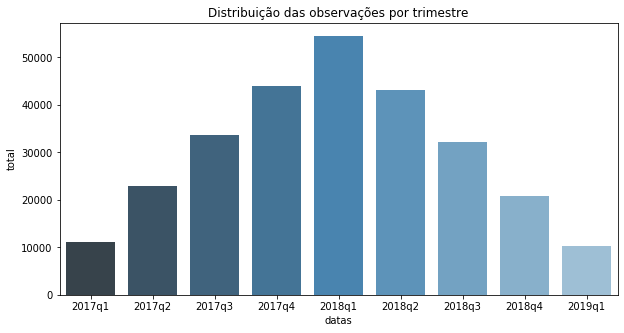

In [5]:
## vendo a distribuição das datas
dist_datas = pd.DataFrame(df['data'].value_counts())
dist_datas['index'] = dist_datas.index

dist_datas.rename(columns={'data':'total','index':'datas'}, inplace=True)
dist_datas.sort_values(by='datas', inplace=True)

fig, axs = plt.subplots(figsize = (10,5))

ax0 = sns.barplot(x="datas", y="total", data=dist_datas, palette="Blues_d")
ax0.set_title("Distribuição das observações por trimestre")

display(dist_datas)

In [6]:
## criando a coluna de identificação dos domicilios
df['iddom'] = df['painel'].astype(int).astype(str) + df['UF'].astype(str)
df['iddom'] = df['iddom'] + df['UPA'].astype(str)

# caso o numero de seleção do domícilio (V1008) seja menor que 10, adicionar um numero 0 no início
df['V1008'] = df['V1008'].astype('int')
df['V1008'] = df['V1008'].apply(lambda i: f"00{i}" if i < 10 else f"{i}")
df['iddom'] = df['iddom'] + df['V1008'].astype(str)

In [7]:
## vendo a composição das primeiras linhas
df[['V1016','iddom','idind']].head(12)

V1016            iddom               idind
0       2  650500000265001  650500000265001001
1       5  650500000265001  650500000265001001
2       3  650500000265001  650500000265001001
3       1  650500000265001  650500000265001001
4       4  650500000265001  650500000265001001
5       5  650500000265001  650500000265001002
6       3  650500000265001  650500000265001002
7       4  650500000265001  650500000265001002
8       1  650500000265001  650500000265001002
9       2  650500000265001  650500000265001002
10      1  650500000265002  650500000265002001
11      2  650500000265002  650500000265002001

In [8]:
## variáveis que possuem os dados de data e individuos
periodos = pd.Categorical(df['data'])
ind = pd.Categorical(df['idind'])

### Criando as dummies para as variáveis de interesse

In [9]:
## primeiro, temos que verificar quais colunas realmente usaremos
colunas = list(df.columns)

In [10]:
desconsiderar = ['Capital','V20082','V3003A','V3004','V3005','V3005A','V3006','V3006A','V3009A','V3011','V3011A','V3012','V4002','V4006','V4006A','V4007','V4008','V40081','V40082','V40083','V40121','V40132','V4014','V4015','V40151','V401511','V401512','V4016','V40161','V40162','V40163','V4017','V40171','V401711','V4018','V40181','V40182','V40183','V4019','V4020','V4021','V4022','V4024','V4025','V4026','V4027','V40331','V40332','V403321','V403322','V40333','V403331','V40342','V403421','V403422','V4039','V4041','V4043','V40431','V4044','V4045','V4046','V4047','V4048','V4049','V40502','V405021','V405022','V40503','V405031','V40512','V405121','V405122','V4056','V4057','V40581','V40582','V405821','V405822','V40583','V405831','V40584','V4059','V40591','V405911','V405912','V40592','V405921','V405922','V4063','V4064','V4072','V4072A','V4074','V4074A','V4075A','V4075A1','V4077','V4078','V4078A','V4082','VD2004','VD4007','VD4015','VD4018','VD4023','VD4030','VD4033','VD4034']

## droppando as colunas
# df = df.drop(colunas[60:80], axis = 1)
# df = df.drop(colunas[35:55], axis = 1)
df = df.drop(desconsiderar, axis = 1)
print(df.shape)

(272698, 113)


In [11]:
####### criando as dummies de cada coluna #######
#### V2005: condicao_familiar_dom
### precisamos coletar dummies de conjugue e numero de filhos para cada observação
## pegando o número de conjugues
# caso fácil: conjugue explicito; caso dificil: responsavel pelo domicilio com conjugue
# caso dificil: responsável pelo domicilio com conjugue
def conjugue(s):
    if (s['V2005'] == 2) or (s['V2005'] == 3) or ((s['V2005'] == 1) and ((s['V2005-1'] == 2) or (s['V2005-1'] == 3))):
        return 1
    else:
        return 0

def conjugue_homo(s):
    if (s['V2005'] == 3) or ((s['V2005'] == 1) and (s['V2005-1'] == 3)):
        return 1
    else:
        return 0

In [12]:
# ordenando o dataframe por domícilio, por data e por condicao
df.sort_values(by=['iddom','data','V2005'], inplace=True)
# criando uma coluna com shift uma linha pra cima
df[['V2005-1']] = df['V2005'].shift(-1)
df[['iddom','data','V2005','V2005-1']].head(15)

iddom    data  V2005  V2005-1
3   650500000265001  2018q1      1      5.0
8   650500000265001  2018q1      5      1.0
0   650500000265001  2018q2      1      5.0
9   650500000265001  2018q2      5      1.0
2   650500000265001  2018q3      1      5.0
6   650500000265001  2018q3      5      1.0
4   650500000265001  2018q4      1      5.0
7   650500000265001  2018q4      5      1.0
1   650500000265001  2019q1      1      5.0
5   650500000265001  2019q1      5      1.0
10  650500000265002  2018q1      1      2.0
16  650500000265002  2018q1      2     10.0
21  650500000265002  2018q1     10     10.0
25  650500000265002  2018q1     10      1.0
11  650500000265002  2018q2      1      2.0

In [13]:
df['casado'] = df.apply(conjugue, axis = 1)
df['casado_homo'] = df.apply(conjugue_homo, axis = 1)
df[['iddom','data','V2005','casado','casado_homo']].head(15)

iddom    data  V2005  casado  casado_homo
3   650500000265001  2018q1      1       0            0
8   650500000265001  2018q1      5       0            0
0   650500000265001  2018q2      1       0            0
9   650500000265001  2018q2      5       0            0
2   650500000265001  2018q3      1       0            0
6   650500000265001  2018q3      5       0            0
4   650500000265001  2018q4      1       0            0
7   650500000265001  2018q4      5       0            0
1   650500000265001  2019q1      1       0            0
5   650500000265001  2019q1      5       0            0
10  650500000265002  2018q1      1       1            0
16  650500000265002  2018q1      2       1            0
21  650500000265002  2018q1     10       0            0
25  650500000265002  2018q1     10       0            0
11  650500000265002  2018q2      1       1            0

In [ ]:
## educação do conjugue
# criando duas colunas auxiliares
df['VD3005-1'] = df['VD3005'].shift(-1)
df['VD3005+1'] = df['VD3005'].shift(1)

## Criando mais colunas auxiliares (uma linha pra cima e uma linha pra baixo)
# para determinar se pessoas estão no mesmo domicílio ou não
df['iddom-1'] = df['iddom'].shift(-1)
df['iddom+1'] = df['iddom'].shift(1)

In [14]:
# Criando e aplicando a função
def educ_conjugue(s):
  ## Se a pessoa estiver registrada como casada, retorne a sua educação
  # (que estará na linha do chefe do domicílio)
    if ((s['V2005'] == 2) or (s['V2005'] == 3)) and (s['iddom'] == s['iddom+1']):
        return s['VD3005+1']

    # Se a pessoa for chefe de domicílio e for casada (cuidado com o domicílio), retorne a educação dessa pessoa
    elif (s['V2005'] == 1) and ((s['V2005-1'] == 2) or (s['V2005-1'] == 3)) and (s['iddom'] == s['iddom-1']):
        return s['VD3005-1']

df['educ_conjugue'] = df.apply(educ_conjugue, axis = 1)

In [15]:
## resetando o index e dropando a coluna shift criada
df.sort_values(by='index', inplace=True)
df = df.drop(['V2005-1','VD3005-1','VD3005+1'], axis = 1)

In [16]:
## vendo a quantidade de cada tipo de condição
df.groupby('V2005')['idind'].count()

V2005
1     94607
2     59958
3       199
4     57992
5     27361
6      5376
7      2040
8      3756
9       700
10    11532
11      343
12     3455
13      172
14     3607
15      650
16      871
17       22
18       55
19        2
Name: idind, dtype: int64

In [17]:
## dummy para chefe de domicílio
df['chefe_dom'] = df['V2005'].apply(lambda i: 1 if i == 1 else 0)

In [18]:
## numero de filhos
# setando o index para iddom, data
df = df.set_index(['iddom','data'])
df.sort_values(by=['iddom','data','idind','V2005'], inplace=True)

In [19]:
## determinar se é filho e depois somar por domicilio
def filho_05(s):
    if (s['V2009'] <= 5) and ((s['V2005'] == 4) or (s['V2005'] == 5) or (s['V2005'] == 6)):
        return 1
    else:
        return 0

def filho_06_10(s):
    if (s['V2009'] >= 6) and (s['V2009'] <= 10) and ((s['V2005'] == 4) or (s['V2005'] == 5) or (s['V2005'] == 6)):
        return 1
    else:
        return 0

def filho_11_18(s):
    if (s['V2009'] <= 18) and (s['V2009'] > 10) and ((s['V2005'] == 4) or (s['V2005'] == 5) or (s['V2005'] == 6)):
        return 1
    else:
        return 0

def filho_18m(s):
    if (s['V2009'] > 18) and ((s['V2005'] == 4) or (s['V2005'] == 5) or (s['V2005'] == 6)):
        return 1
    else:
        return 0

def filho(s):
    if (s['V2005'] == 4) or (s['V2005'] == 5) or (s['V2005'] == 6):
        return 1
    else:
        return 0

In [20]:
## criando as colunas
df['filho'] = df.apply(filho, axis = 1)
df['filho_05'] = df.apply(filho_05, axis = 1)
df['filho_06_10'] = df.apply(filho_06_10, axis = 1)
df['filho_11_18'] = df.apply(filho_11_18, axis = 1)
df['filho_18m'] = df.apply(filho_18m, axis = 1)

In [21]:
filhos = pd.DataFrame(df[['filho','filho_05','filho_06_10','filho_11_18','filho_18m']].groupby(['iddom','data']).sum())
filhos.rename(columns={'filho':'num_filhos','filho_05':'num_filhos_05', 'filho_06_10':'num_filhos_06_10', 'filho_11_18':'num_filhos_11_18', 'filho_18m':'num_filhos_18m'}, inplace=True)
filhos

num_filhos  num_filhos_05  num_filhos_06_10  \
iddom           data                                                  
650500000265001 2018q1           1              0                 0   
                2018q2           1              0                 0   
                2018q3           1              0                 0   
                2018q4           1              0                 0   
                2019q1           1              0                 0   
...                            ...            ...               ...   
65353005106713  2018q4           0              0                 0   
65353005106714  2018q1           1              1                 0   
                2018q2           1              1                 0   
                2018q3           0              0                 0   
                2018q4           0              0                 0   

                        num_filhos_11_18  num_filhos_18m  
iddom           data                                      
650500000265001 2018q1                 1               0  
                2018q2                 1               0  
                2018q3                 1               0  
                2018q4                 1               0  
                2019q1                 1               0  
...                                  ...             ...  
65353005106713  2018q4                 0               0  
65353005106714  2018q1                 0               0  
                2018q2                 0               0  
                2018q3                 0               0  
                2018q4                 0               0  

[94607 rows x 5 columns]

In [22]:
## juntando ao dataframe
df = df.join(filhos, on=['iddom','data'])

In [23]:
## arrumando as colunas (estão populadas por 1)
def num_filhos(s):
    global column
    if s['V2005'] > 3:
        return 0
    else:
        return s[column]

for column in ['num_filhos','num_filhos_05','num_filhos_06_10','num_filhos_11_18','num_filhos_18m']:
    df[column] = df.apply(num_filhos, axis = 1)

In [24]:
## idadesq
df['idadesq'] = df['V2009']**2

In [25]:
## V2007: sexo (mulher, mais especificamente)
df['V2007'] = df['V2007'] - 1

In [26]:
## V2010: cor
# substituindo os numeros pelo nomes
df["V2010"].replace([1,2,3,4,5,9], ['branca','preta','amarela','parda','indigena',np.nan], inplace=True)

In [27]:
## separando apenas entre branco/amarelo e preto_pardo_indigena
def cor2(s):
    if (s['V2010'] == 'branca') or (s['V2010'] == 'amarela'):
        return "branca_am"
    elif(s['V2010'] == 'preta') or (s['V2010'] == 'parda') or (s['V2010'] == 'indigena'):
        return "preta_parda_ind"

df['cor2'] = df.apply(cor2, axis = 1)

In [28]:
## vendo a distribuicao de cores
df['V2010'].value_counts()

parda       147866
branca       99357
preta        22582
amarela       1742
indigena      1129
Name: V2010, dtype: int64

In [29]:
## criando as dummies e juntando-as ao dataframe
df = pd.concat([df,pd.get_dummies(df['V2010'])], axis = 1)

In [30]:
# criando outras duas dummies: preta_parda e minoria
def preta_parda_ind(s):
    if (s['preta'] == 1) or (s['parda'] == 1) or (s['indigena'] == 1):
        return 1
    else:
        return 0
def minoria(s):
    if (s['preta'] == 1) or (s['parda'] == 1) or (s['amarela'] == 1) or (s['indigena'] == 1):
        return 1
    else:
        return 0

df['preta_parda_ind'] = df.apply(preta_parda_ind, axis = 1)
df['minoria'] = df.apply(minoria, axis = 1)

In [31]:
## V3001: alfabetizado
df['V3001'] = df['V3001'].apply(lambda i: 1 if i == 1 else 0)

## V3002: frequenta escola atualmente
df['V3002'] = df['V3002'].apply(lambda i: 1 if i == 1 else 0)

## V3002A: escola publica ou privada
df['V3002A'] = df['V3002A'] - 1

## V3007: dupla graduacao
df['V3007'] = df['V3007'].apply(lambda i: 1 if i == 1 else 0)

## V3008: já frequentou escola 
df['V3008'] = df['V3008'].apply(lambda i: 1 if i == 1 else 0)

## outras variáveis legais: 3003A e 3009A

In [32]:
#### variáveis derivadas ######
## grau de educ
# substituindo os numeros pelo nomes
df["VD3004"].replace([1,2,3,4,5,6,7], ['sem_instrucao','fund_incompleto','fund_completo','medio_incompleto','medio_completo','superior_incompleto','superior_completo'], inplace= True)
df['VD3004'].value_counts()

fund_incompleto        96866
medio_completo         53854
superior_completo      33158
fund_completo          19917
sem_instrucao          19380
medio_incompleto       19026
superior_incompleto    12925
Name: VD3004, dtype: int64

In [33]:
## criando as dummies e juntando-as ao dataframe
df = pd.concat([df,pd.get_dummies(df['VD3004'])], axis = 1)

In [34]:
## VD4001: força de trabalho (mais especificamente, fora dela)
df['VD4001'] = df['VD4001'] - 1

## VD4002: ocupação (mais especificamente, pessoas desocupadas)
df['VD4002'] = df['VD4002'] - 1

## VD 4012: contribuinte previdencia
df['V3007'] = df['V3007'].apply(lambda i: 1 if i == 1 else 0)

## outros legais: VD4008 e VD4009 (ocupacao), VD4010 e VD4011 (setor de ocupação)

In [35]:
#### dummies de ocupação ######
## tipo de trabalho
# mais agregado
df['VD4008'].replace([1,2,3,4,5,6], ['privado','domestico','publico','empregador','conta_propria','familiar'], inplace=True)
df = pd.concat([df,pd.get_dummies(df['VD4008'])], axis = 1)
df = df.drop(['conta_propria','familiar'], axis = 1)

# desagregado
df["VD4009"].replace([1,2,3,4,5,6,7,8,9,10], ['privado_formal','privado_informal','domestico_formal','domestico_informal','publico_formal','publico_informal','militar','empregador1','conta_propria','familiar'], inplace= True)
df = pd.concat([df,pd.get_dummies(df['VD4009'])], axis = 1)

In [36]:
print(df['VD4008'].value_counts())
print(df['VD4009'].value_counts())

privado          61077
conta_propria    31477
publico          17954
domestico         9965
empregador        6639
familiar          2323
Name: VD4008, dtype: int64
privado_formal        46624
conta_propria         31477
privado_informal      14453
militar               12759
empregador1            6639
domestico_informal     6375
publico_informal       3941
domestico_formal       3590
familiar               2323
publico_formal         1254
Name: VD4009, dtype: int64


In [37]:
## setor de ocupação
df['VD4010'] = df['VD4010'].replace([1,2,3,4,5,6,7,8,9,10,11,12], ['agro','industria','construcao','comercio','transporte','aloj_alim','servicos','adm_publica','educ_saude','outros_servicos','servicos_domesticos','ativ_mal_definidas'])
df = pd.concat([df,pd.get_dummies(df['VD4010'])], axis = 1)

In [38]:
#### variáveis de identificacao ####
## V1022: domicilios rurais
df['rural'] = df['V1022'] - 1

## V1023: tipos de área
df["V1023"] = df["V1023"].replace([1,2,3,4], ['capital','reg_metro','ride','resto_uf'])
df = pd.concat([df,pd.get_dummies(df['V1023'])], axis = 1)

## UF
df['UF'] = df['UF'].replace([50, 51, 52, 53], ['MS','MT','GO','DF'])
df = pd.concat([df,pd.get_dummies(df['UF'])], axis = 1)

### Nomeando as colunas mais importantes e fazendo a estrutura de painel

In [39]:
## dando nome apenas às colunas mais importantes
nomes_condicoes_gerais = {'V2007':'feminino','V2009':'idade','V2010':'cor','V3001':'alfabet','V3002':'frequenta_escola','V3002A':'escola_publica','V3003':'maior_curso_que_frequenta','V3007':'dupla_graduacao','V3008':'frequentou_escola','V3009':'maior_curso_que_frequentou'}

nomes_variaveis_derivadas = {'V4040':'tempo_de_trabalho','VD2002':'condicao_familiar_dom','VD2003':'num_pessoas_dom', 'VD3004':'grau_educ','VD3005':'educ','VD3006':'faixa_educ','VD4001':'fora_ft','VD4002':'desocupado','VD4003':'fora_ft_dentro_ft_potencial','VD4004':'subocupado_efetiva','VD4004A':'subocupado_habitual','VD4005':'desalentado','VD4008':'pos_ocupacao_agg','VD4009':'pos_ocupacao','VD4010':'setor_ocupacao','VD4011':'setor_ocupacao2','VD4012':'cont_prev','VD4013':'faixa_horas_hab_total','VD4014':'faixa_horas_efet_total','VD4016':'renda_hab_prin','VD4017':'renda_efet_prin','VD4019':'renda_hab_tot','VD4020':'renda_efet_tot','VD4031':'horas_hab_tot','VD4032':'horas_efet_prin','VD4035':'horas_efet_tot','VD4036':'faixa_horas_hab_prin','VD4037':'faixa_horas_efet_prin'}

## ATENÇÃO: O PAINEL SÓ CONTÉM DADOS DE RENDIMENTOS DO TRABALHO (sem benefícios previdenciários)

In [40]:
## renomeando
df.rename(columns = nomes_condicoes_gerais, inplace = True)
df.rename(columns = nomes_variaveis_derivadas, inplace = True)

In [41]:
## comparando renda efetiva e renda habitual
df[['renda_hab_tot','renda_hab_prin','renda_efet_tot','renda_efet_prin','horas_hab_tot','horas_efet_tot']].describe()

renda_hab_tot  renda_hab_prin  renda_efet_tot  renda_efet_prin  \
count  126988.000000   126972.000000   126988.000000    126972.000000   
mean     2373.880886     2315.292372     2452.236589      2395.851818   
std      3723.554758     3556.161182     3994.870570      3867.482208   
min         7.000000        7.000000        0.000000         0.000000   
25%      1000.000000      998.000000      957.000000       954.000000   
50%      1500.000000     1500.000000     1500.000000      1500.000000   
75%      2500.000000     2500.000000     2500.000000      2500.000000   
max    265000.000000   265000.000000   300000.000000    300000.000000   

       horas_hab_tot  horas_efet_tot  
count  129435.000000   129435.000000  
mean       40.294078       38.408738  
std        11.966331       14.048278  
min         1.000000        0.000000  
25%        40.000000       32.000000  
50%        40.000000       40.000000  
75%        44.000000       44.000000  
max       120.000000      120.000000

In [42]:
## exportando para csv
# df[['renda_hab_tot','renda_hab_prin','renda_efet_tot','renda_efet_prin']].describe().to_csv('renda_hab_efet.csv')

In [43]:
print(f"Quantidade de indivíduos com renda efetiva = 0: {len(df['renda_efet_prin'].loc[df['renda_efet_prin'] == 0])}")
print(f"Quantidade de indivíduos com renda habitual = 0: {len(df['renda_hab_prin'].loc[df['renda_hab_prin'] == 0])}")

Quantidade de indivíduos com renda efetiva = 0: 3109
Quantidade de indivíduos com renda habitual = 0: 0


In [44]:
## somando a renda habitual do domicilio
renda = pd.DataFrame(df[['renda_efet_prin','renda_hab_prin']].groupby(['iddom','data']).sum())
renda.rename(columns={'renda_hab_prin':'renda_hab_domiciliar','renda_efet_prin':'renda_efet_domiciliar'}, inplace=True)
renda

renda_efet_domiciliar  renda_hab_domiciliar
iddom           data                                               
650500000265001 2018q1                 1000.0                1554.0
                2018q2                  300.0                 400.0
                2018q3                  954.0                 954.0
                2018q4                 1054.0                1054.0
                2019q1                  954.0                 988.0
...                                       ...                   ...
65353005106713  2018q4                    0.0                   0.0
65353005106714  2018q1                 1200.0                1200.0
                2018q2                 1000.0                1000.0
                2018q3                  350.0                 400.0
                2018q4                  700.0                 800.0

[94607 rows x 2 columns]

In [45]:
## juntando as contas ao df original e vendo o resultado
df = df.join(renda, on=['iddom','data'])

In [46]:
## criando variável de salário por hora (habitual e efetivo) (*4 porque são 4 semanas no mes, tipicamente)
df['renda_hab_hora'] = df['renda_hab_prin']/(df['horas_hab_tot']*4)
df['renda_efet_hora'] = df['renda_efet_prin']/(df['horas_efet_tot']*4)

df['lsalariohora'] = np.log(df['renda_hab_hora'])

In [47]:
## criando colunas da renda domiciliar per capita (exclusive pensionistas)
df['renda_hab_domiciliar_pc'] = df['renda_hab_domiciliar']/df['num_pessoas_dom']
df['renda_efet_domiciliar_pc'] = df['renda_efet_domiciliar']/df['num_pessoas_dom']

In [48]:
## salario minimo dos anos
sal_minimo = {2017:937,2018:954,2019:998}

def faixa_salario_minimo(s):
    if s['Ano'] == 2017:
        if s['renda_hab_domiciliar_pc'] < sal_minimo[2017]/4: ## linha de pobreza do BPC
            return "1/4_SM"
        elif s['renda_hab_domiciliar_pc'] < sal_minimo[2017]/2:
            return "1/2_SM"
        elif s['renda_hab_domiciliar_pc'] < sal_minimo[2017]:
            return "1_SM" 
        elif s['renda_hab_domiciliar_pc'] < 2*sal_minimo[2017]:
            return "2_SM"
        elif s['renda_hab_domiciliar_pc'] < 5*sal_minimo[2017]:
            return "5_SM"
        elif s['renda_hab_domiciliar_pc'] < 10*sal_minimo[2017]:
            return "10_SM"
        else:
            return "+10_SM"
    elif s['Ano'] == 2018:
        if s['renda_hab_domiciliar_pc'] < sal_minimo[2018]/4:
            return "1/4_SM"
        elif s['renda_hab_domiciliar_pc'] < sal_minimo[2018]/2:
            return "1/2_SM"
        elif s['renda_hab_domiciliar_pc'] < sal_minimo[2018]:
            return "1_SM" 
        elif s['renda_hab_domiciliar_pc'] < 2*sal_minimo[2018]:
            return "2_SM"
        elif s['renda_hab_domiciliar_pc'] < 5*sal_minimo[2018]:
            return "5_SM"
        elif s['renda_hab_domiciliar_pc'] < 10*sal_minimo[2018]:
            return "10_SM"
        else:
            return "+10_SM"
    else:
        if s['renda_hab_domiciliar_pc'] < sal_minimo[2019]/4:
            return "1/4_SM"
        elif s['renda_hab_domiciliar_pc'] < sal_minimo[2019]/2:
            return "1/2_SM"
        elif s['renda_hab_domiciliar_pc'] < sal_minimo[2019]:
            return "1_SM" 
        elif s['renda_hab_domiciliar_pc'] < 2*sal_minimo[2019]:
            return "2_SM"
        elif s['renda_hab_domiciliar_pc'] < 5*sal_minimo[2019]:
            return "5_SM"
        elif s['renda_hab_domiciliar_pc'] < 10*sal_minimo[2019]:
            return "10_SM"
        else:
            return "+10_SM"

## criando a coluna com as faixas de salário mínimo
df['sal_minimo'] = df.apply(faixa_salario_minimo, axis = 1)

## criando as dummies e juntando-as ao dataframe
df = pd.concat([df,pd.get_dummies(df['sal_minimo'])], axis = 1)

## explicitando a linha de pobreza do pc
df['pobreza_bpc'] = df['1/4_SM']

In [49]:
## criando uma dummy para pobreza e para extrema pobreza (considerando a renda efetiva para captar sazonalidades) 
# extrema pobreza: 85 reais por domicílio por pessoa (2017) ou 89 (2018 e 2019)
# pobreza: 170 reais por domicílio por pessoa ou 178 (2018 e 2019)

def pobreza(s):
    if s['Ano'] == 2017 and s['renda_efet_domiciliar_pc'] <= 170:
        return 1
    elif s['renda_efet_domiciliar_pc'] <= 178:
        return 1
    else:
        return 0

def ex_pobreza(s):
    if s['Ano'] == 2017 and s['renda_efet_domiciliar_pc'] <= 85:
        return 1
    elif s['renda_efet_domiciliar_pc'] <= 89:
        return 1
    else:
        return 0

df['ex_pobreza'] = df.apply(ex_pobreza, axis = 1)
df['pobreza'] = df.apply(pobreza, axis = 1)

##pobreza para o banco mundial: 5,50 dolares; ex_pobreza: 1,90 dolares por dia
# esse valor é obtido via paridade do poder de compra, e não do cambio propriamente dito
cambio = [3.14,3.22,3.15,3.25,3.24,3.62,3.94,3.8,3.78]

linha_pobreza = np.around([5.5*30*i for i in cambio],2)
media_linha_pobreza = np.average(linha_pobreza)

linha_extrema_pobreza = np.around([1.9*30*i for i in cambio],2)
media_linha_extrema_pobreza = np.average(linha_extrema_pobreza)
'''
## criando as dummies usando a linha de pobreza do banco mundial
df['ex_pobrezabm'] = df['renda_hab_domiciliar_pc'].apply(lambda i: 1 if i <= media_linha_extrema_pobreza else 0)
df['pobrezabm'] = df['renda_hab_domiciliar_pc'].apply(lambda i: 1 if i <= media_linha_pobreza else 0)
'''
print(f"Linha de Pobreza: {media_linha_pobreza}\nLinha de Extrema Pobreza: {media_linha_extrema_pobreza}")

Linha de Pobreza: 570.9
Linha de Extrema Pobreza: 197.22


In [50]:
## vendo pobres pelo gov federal
print(df['ex_pobreza'].value_counts())
print(df['pobreza'].value_counts())

0    233508
1     39190
Name: ex_pobreza, dtype: int64
0    224810
1     47888
Name: pobreza, dtype: int64


### Fazendo o painel (individuo, data), arrumando os tipos das colunas e exportando pra .dta

In [49]:
# resetando o index
df = df.reset_index(drop=False)
df.sort_values(by=['index'], inplace=True)
df.set_index('index', inplace=True)

In [50]:
# droppando valores nulos
# df.dropna(subset=['renda_hab_tot', 'renda_efet_tot', 'educ', 'idade', 'cor', 'feminino'], axis = 0, inplace=True)

In [51]:
### caso precise voltar a forma antiga
# setando o index para iddom, data
## df = df.set_index(['iddom','data'])
# df.sort_values(by=['iddom','data','idind','condicao_familiar_dom'], inplace=True)

In [52]:
## vendo quais colunas são do tipo objeto
print(list(df.select_dtypes(include=['object']).columns))

['iddom', 'data', 'Trimestre', 'UF', 'V1008', 'V1023', 'cor', 'grau_educ', 'pos_ocupacao_agg', 'pos_ocupacao', 'setor_ocupacao', 'idind', 'cor2', 'sal_minimo']


In [53]:
## mudando os tipos das colunas da lista anterior
df['iddom'] = df['iddom'].astype('int')
df['Trimestre'] = df['Trimestre'].astype('int')
df['V1008'] = df['V1008'].astype('int')
df['idind'] = df['idind'].astype('int')

df['V1023'] = df['V1023'].astype('category')
df['data'] = df['data'].astype('category')
df['cor'] = df['cor'].astype('category')
df['grau_educ'] = df['grau_educ'].astype('category')
df['pos_ocupacao'] = df['pos_ocupacao'].astype('category')
df['pos_ocupacao_agg'] = df['pos_ocupacao_agg'].astype('category')
df['setor_ocupacao'] = df['setor_ocupacao'].astype('category')

In [54]:
## fazendo estrutura de painel (dfp = df_painel)
dfp = df.reset_index(drop=False).set_index(['idind','data'])

## para ter as colunas fora do index também
dfp['data1'] = periodos
dfp['idind1'] = ind

## deixando as linhas em ordem
dfp.sort_values(by=['idind','data'], inplace = True)

## selecionando apenas as linhas com idade entre 15 e 64
dfp1 = dfp.loc[dfp['idade'] >= 18]
dfp1 = dfp.loc[dfp['idade'] < 65]

In [55]:
## vendo quantos individuos tem e o df final (com apenas 15 a 64 anos)
print("De 18 a 64 anos: ", dfp1['idind1'].nunique())
print("Total: ", dfp['idind1'].nunique())
display(dfp1)
## num linhas: 191016

De 18 a 64 anos:  69011
Total:  74891


index            iddom   Ano  Trimestre  UF  \
idind              data                                                   
650500000265001001 2018q1       3  650500000265001  2018          1  MS   
                   2018q2       0  650500000265001  2018          2  MS   
                   2018q3       2  650500000265001  2018          3  MS   
                   2018q4       4  650500000265001  2018          4  MS   
                   2019q1       1  650500000265001  2019          1  MS   
...                           ...              ...   ...        ...  ..   
653530051067014001 2018q2  272692   65353005106714  2018          2  DF   
653530051067014002 2018q1  272695   65353005106714  2018          1  DF   
                   2018q2  272694   65353005106714  2018          2  DF   
653530051067014201 2018q3  272697   65353005106714  2018          3  DF   
                   2018q4  272696   65353005106714  2018          4  DF   

                           RM_RIDE        UPA  Estrato  V1008  V1014  ...  \
idind              data                                               ...   
650500000265001001 2018q1      NaN  500000265  5051010      1      6  ...   
                   2018q2      NaN  500000265  5051010      1      6  ...   
                   2018q3      NaN  500000265  5051010      1      6  ...   
                   2018q4      NaN  500000265  5051010      1      6  ...   
                   2019q1      NaN  500000265  5051010      1      6  ...   
...                            ...        ...      ...    ...    ...  ...   
653530051067014001 2018q2      NaN  530051067  5310211     14      6  ...   
653530051067014002 2018q1      NaN  530051067  5310211     14      6  ...   
                   2018q2      NaN  530051067  5310211     14      6  ...   
653530051067014201 2018q3      NaN  530051067  5310211     14      6  ...   
                   2018q4      NaN  530051067  5310211     14      6  ...   

                           +10_SM  1/2_SM 1/4_SM  10_SM  1_SM  2_SM  5_SM  \
idind              data                                                     
650500000265001001 2018q1       0       0      0      0     1     0     0   
                   2018q2       0       0      1      0     0     0     0   
                   2018q3       0       0      0      0     1     0     0   
                   2018q4       0       0      0      0     1     0     0   
                   2019q1       0       1      0      0     0     0     0   
...                           ...     ...    ...    ...   ...   ...   ...   
653530051067014001 2018q2       0       0      0      0     1     0     0   
653530051067014002 2018q1       0       0      0      0     1     0     0   
                   2018q2       0       0      0      0     1     0     0   
653530051067014201 2018q3       0       1      0      0     0     0     0   
                   2018q4       0       0      0      0     1     0     0   

                           pobreza_bpc   data1              idind1  
idind              data                                             
650500000265001001 2018q1            0  2018q1  650500000265001001  
                   2018q2            1  2018q2  650500000265001001  
                   2018q3            0  2018q3  650500000265001001  
                   2018q4            0  2018q4  650500000265001001  
                   2019q1            0  2019q1  650500000265001001  
...                                ...     ...                 ...  
653530051067014001 2018q2            0  2018q2  653530051067014001  
653530051067014002 2018q1            0  2018q1  653530051067014002  
                   2018q2            0  2018q2  653530051067014002  
653530051067014201 2018q3            0  2018q3  653530051067014201  
                   2018q4            0  2018q4  653530051067014201  

[246871 rows x 194 columns]

In [56]:
## exportando pra csv
#df1 = df.drop(['1/4_SM','1/2_SM','1_SM','2_SM','5_SM','10_SM'], axis = 1)
#df1.to_csv('pnad_co_filtrada3.csv')

## Análises descritivas

Análise descritiva das variáveis e criação de modelos e testes de regressão.

Faremos a análise dos rendimentos e do desemprego por:

- por cor (cor);
- por gênero (feminino);
- por região da UF (V1023 e capital e rural e UF)
- por faixa de educação (grau_educ)
- por ocupação (ocupado ou não) (desocupado)
- por setor de ocupação (agro, indústria...) (setor_ocupacao)
- por posicao de ocupação (publico/privado, formal/informal) (pos_ocupacao_agg e pos_ocupacao)
- por faixa de salário mínimo (sal_minimo)

Por fim, serão feitas análises de **desigualdade, pobreza e desemprego** por **UF** e por **cor** (o foco do trabalho), considerando apenas o 2018q1 (trimestre com maior número de observações)

### Estatísticas das colunas criadas

Dummy de área urbana, dummies de estado, número de filhos, dummy de sexo, (homem ou mulher), dummies de raça, anos de educação, graus de educação

In [59]:
# setando o index para iddom, data
df = df.set_index(['iddom','data'])

## colocando apenas as pessoas em idade economicamente ativa
df = df.loc[df['idade'] >= 18]
df = df.loc[df['idade'] < 65]

df.sort_values(by=['iddom','data','idind'], inplace=True)
print(df.shape)

(178200, 191)


In [60]:
## configurando o estilo dos plots
sns.set_style(style="white")
from matplotlib.colors import ListedColormap

**Cor**

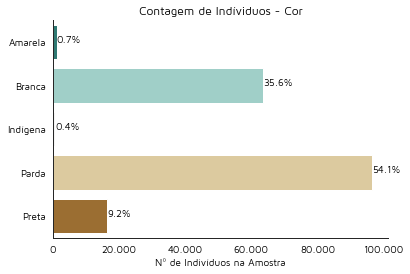

cor     amarela  branca  indigena  parda  preta  Total
data                                                  
2017q1       58    2569        26   4026    667   7346
2017q2       98    5195        57   8239   1276  14865
2017q3      134    7857        94  11988   1958  22031
2017q4      165   10191        99  15644   2666  28765
2018q1      202   12733       127  19334   3303  35699
2018q2      210   10105       140  15123   2636  28214
2018q3      141    7560       109  11206   1932  20948
2018q4      120    4887        60   7195   1282  13544
2019q1       48    2403        20   3664    643   6778

In [61]:
##objeto gráfico
labels_eixo_x = ['Amarela','Branca','Indígena', 'Parda','Preta']

## começando a criar o gráfico
ax1 = sns.countplot(y='cor', data = df, palette="BrBG_r")

## alterando as categorias do eixo x
ax1.set_yticks([0,1,2,3,4])
ax1.set_yticklabels(labels = labels_eixo_x,
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_xticks()]
ax1.set_xticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Contagem de Indíviduos - Cor", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## plotando as porcentagens nas barras
total = len(df['cor'])
for p in ax1.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total).replace(',', '.')
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax1.annotate(percentage, (x, y), fontname = 'Maven Pro', color = 'k')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

# plt.savefig('amostra_cor.png', dpi = 300)
plt.show()

## vendo o total por data
cor_data = df.groupby(['data','cor']).size().unstack()
cor_data.columns = cor_data.columns.astype(str)
cor_data['Total'] = cor_data.sum(axis=1)

display(cor_data)
## legal mencionar que amarelos e indígenas tem amostras bastante pequenas

In [62]:
### POR UF
### criando o objeto principal
## criando o dataframe
g = df.groupby(['cor', 'UF']).size().reset_index().pivot(columns='cor', index='UF', values=0)

# modificando as colunas para permitir a soma de cada categoria
g.columns = g.columns.astype(str)
g['total'] = g.sum(axis=1)

# criando um g com valores percentuais
g1 = g[['amarela','branca','indigena','parda','preta']].div(g.total, axis = 0)

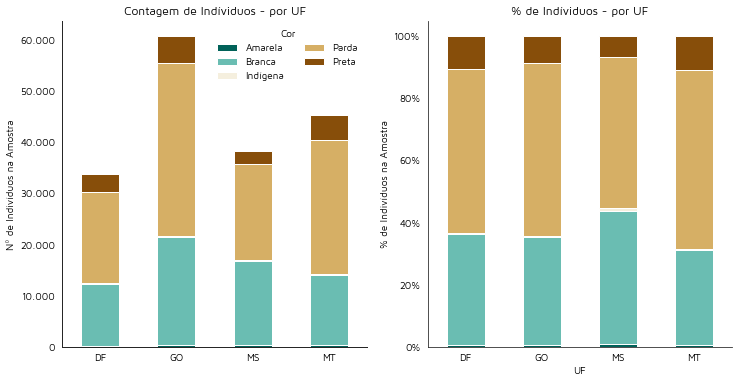

cor    amarela  branca  indigena  parda  preta   total
UF                                                    
DF         233   12039       134  17799   3553   33758
GO         278   21262       130  33839   5237   60746
MS         339   16432       293  18597   2612   38273
MT         326   13767       175  26184   4961   45413
Total     1176   63500       732  96419  16363  178190

In [63]:
##objeto gráfico
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## começando a criar o 1º gráfico
ax1 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0])

## alternado a legenda
ax1.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 2, frameon = False)
plt.setp(ax1.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax1.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(labels = ['DF','GO','MS','MT'],
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Contagem de Indíviduos - por UF", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

########################################
## começando a criar o 2º gráfico
ax2 = g1[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1])
ax2.legend([],[], frameon=False)

## alterando as categorias do eixo x
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(labels = ['DF','GO','MS','MT'],
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in ax2.get_yticks()]
ax2.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax2.set_title("% de Indíviduos - por UF", color = 'k',fontname = 'Maven Pro')
ax2.set_xlabel("UF", color = 'k',fontname = 'Maven Pro')
ax2.set_ylabel("% de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

## mostrando o plot
plt.savefig("amostra_uf_cor.png", dpi = 300)
plt.show()

## Mostrando g com a coluna e linha de soma
display(g.append(g.sum().rename('Total')))

**Gênero**

In [64]:
##  contagem de indivíduos por sexo
## criando o dataframe
g = df.groupby(['cor', 'feminino']).size().reset_index().pivot(columns='cor', index='feminino', values=0)

# modificando as colunas para permitir a soma de cada categoria
g.columns = g.columns.astype(str)
g['total'] = g.sum(axis=1)

# criando um g com valores percentuais
g1 = g[['amarela','branca','indigena','parda','preta']].div(g.total, axis = 0)

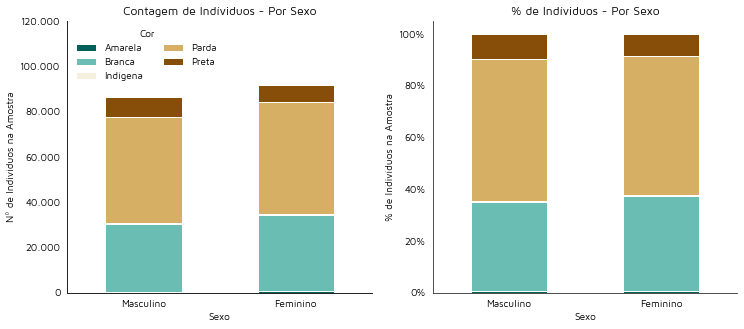

cor       amarela  branca  indigena  parda  preta   total
feminino                                                 
0             573   29782       344  47097   8519   86315
1             603   33718       388  49322   7844   91875
Total        1176   63500       732  96419  16363  178190

In [65]:
#objeto gráfico
fig, ax = plt.subplots(ncols= 2, figsize = (12,5))

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']
labels_eixo_x = ['Masculino', 'Feminino']

## começando a criar o 1º gráfico
ax1 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0])

## alternado a legenda
ax1.legend(title = 'Cor', labels = labels_legenda, loc='upper left',ncol = 2, frameon = False)
plt.setp(ax1.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax1.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
ax1.set_xticks([0,1])
ax1.set_xticklabels(labels = labels_eixo_x,
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
ax1.set_ylim(0,120000)
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Contagem de Indíviduos - Por Sexo", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("Sexo", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

########################################
## começando a criar o 2º gráfico
ax2 = g1[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1])
ax2.legend([],[], frameon=False)

## alterando as categorias do eixo x
ax2.set_xticks([0,1])
ax2.set_xticklabels(labels = labels_eixo_x,
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in ax2.get_yticks()]
ax2.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax2.set_title("% de Indíviduos - Por Sexo", color = 'k',fontname = 'Maven Pro')
ax2.set_xlabel("Sexo", color = 'k',fontname = 'Maven Pro')
ax2.set_ylabel("% de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

## mostrando o plot
#plt.savefig("amostra_genero_cor.png", dpi = 300)
plt.show()
display(g.append(g.sum().rename('Total')))

**Urbano x Rural**

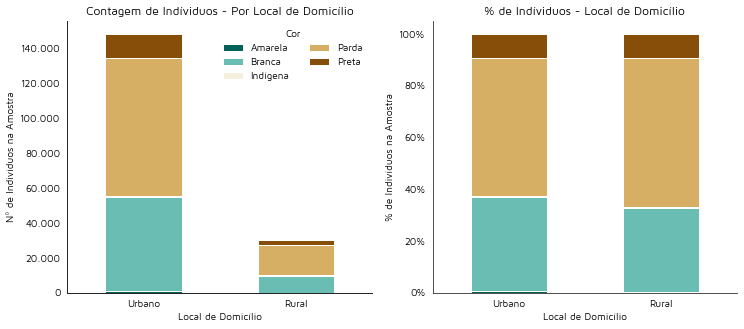

cor    amarela  branca  indigena  parda  preta   total
rural                                                 
0         1040   53854       541  79262  13532  148229
1          136    9646       191  17157   2831   29961
Total     1176   63500       732  96419  16363  178190

In [123]:
## criando o objeto principal
g = df.groupby(['cor', 'rural']).size().reset_index().pivot(columns='cor', index='rural', values=0)

# modificando as colunas para permitir a soma de cada categoria
g.columns = g.columns.astype(str)
g['total'] = g.sum(axis=1)

# criando um g com valores percentuais
g2 = g[['amarela','branca','indigena','parda','preta']].div(g.total, axis = 0)

#objeto gráfico
fig, ax = plt.subplots(ncols= 2, figsize = (12,5))

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']
labels_eixo_x = ['Urbano', 'Rural']

## começando a criar o 1º gráfico
ax1 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0])
ax2 = g2[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1])

## alternado a legenda
ax1.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 2, frameon = False)
plt.setp(ax1.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax1.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
for graph in [ax1,ax2]:
  graph.set_xticks([0,1])
  graph.set_xticklabels(labels = labels_eixo_x, rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Contagem de Indíviduos - Por Local de Domicílio", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("Local de Domicílio", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

########################################
## começando a criar o 2º gráfico
ax2.legend([],[], frameon=False)

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in ax2.get_yticks()]
ax2.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax2.set_title("% de Indíviduos - Local de Domicílio", color = 'k',fontname = 'Maven Pro')
ax2.set_xlabel("Local de Domicílio", color = 'k',fontname = 'Maven Pro')
ax2.set_ylabel("% de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

## mostrando o plot
#plt.savefig("amostra_urbanorural_cor.png", dpi = 300)
plt.show()
display(g.append(g.sum().rename('Total')))

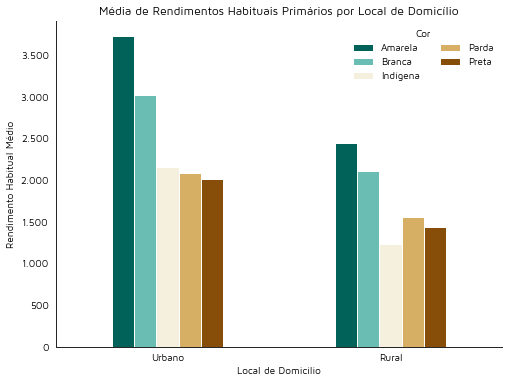

In [127]:
## vendo a renda média por grupo
## calculando a média de rendimento efetivos totais por cor e educ
g = df.groupby(['rural','cor'])['renda_hab_prin'].mean().unstack()

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## começando a criar o 1º gráfico
ax1 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), figsize = (8,6))

## alternado a legenda
ax1.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 2, frameon = False)
plt.setp(ax1.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax1.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
ax1.set_xticks([0,1])
ax1.set_xticklabels(labels = ['Urbano','Rural'],rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Média de Rendimentos Habituais Primários por Local de Domicílio", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("Local de Domicilio", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Rendimento Habitual Médio", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

#plt.savefig("media_rendahabprin_urbanorural_cor.png", dpi = 300)
plt.show()

In [124]:
## estatísticas de renda por local de domicilio; rural tem renda média menor, mas maior desvio padrão
df.groupby('rural')['renda_hab_prin'].describe()

count      mean       std     min       25%       50%       75%  \
rural                                                                         
0     101523.0000 2438.3827 3392.1370 10.0000 1000.0000 1500.0000 2500.0000   
1      18587.0000 1726.6329 3603.2614  7.0000  937.0000 1300.0000 1969.0000   

              max  
rural              
0     250000.0000  
1     229000.0000

**Grau de Educação**

In [67]:
### GRAU DE EDUCAÇÃO
### criando o objeto principal
## criando o dataframe
g = df.groupby(['cor', 'grau_educ']).size().reset_index().pivot(columns='cor', index='grau_educ', values=0)

# modificando as colunas para permitir a soma de cada categoria
g.columns = g.columns.astype(str)
g['total'] = g.sum(axis=1)

# reordenando o index
list_ordering = ["sem_instrucao","fund_incompleto","fund_completo","medio_incompleto","medio_completo",'superior_incompleto','superior_completo']
g = g.reindex(list_ordering) 

# criando um g com valores percentuais
g1 = g[['amarela','branca','indigena','parda','preta']].div(g.total, axis = 0)

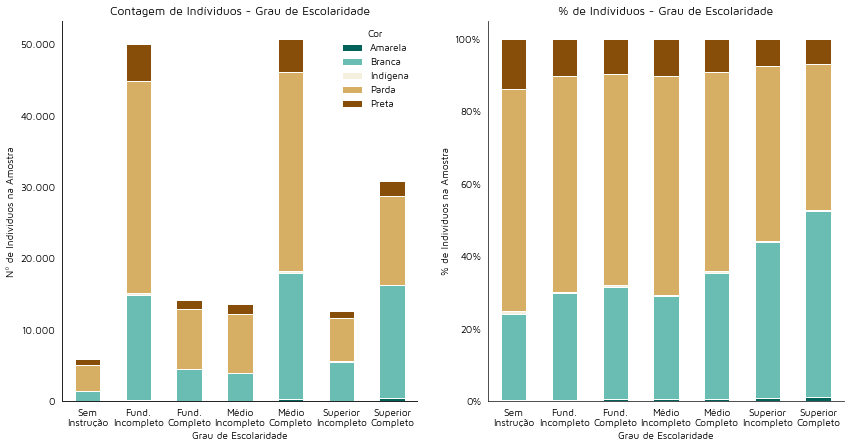

cor                  amarela  branca  indigena  parda  preta   total
grau_educ                                                           
sem_instrucao             17    1416        40   3632    814    5919
fund_incompleto          177   14750       249  29710   5172   50058
fund_completo             80    4418        70   8309   1367   14244
medio_incompleto          82    3885        50   8231   1372   13620
medio_completo           305   17736       195  27946   4553   50735
superior_incompleto      107    5472        44   6122    957   12702
superior_completo        408   15823        84  12469   2128   30912
Total                   1176   63500       732  96419  16363  178190

In [68]:
##objeto gráfico
fig, ax = plt.subplots(ncols = 2, figsize = (14,7))

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']
labels_eixo_x = [
    "Sem\nInstrução","Fund.\nIncompleto","Fund.\nCompleto","Médio\nIncompleto","Médio\nCompleto", "Superior\nIncompleto", "Superior\nCompleto"
    ]

## começando a criar o 1º gráfico
ax1 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0])

## alternado a legenda
ax1.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 1, frameon = False)
plt.setp(ax1.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax1.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
ax1.set_xticks([0,1,2,3,4,5,6])
ax1.set_xticklabels(labels = labels_eixo_x,
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Contagem de Indíviduos - Grau de Escolaridade", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("Grau de Escolaridade", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

########################################
## começando a criar o 2º gráfico
ax2 = g1[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1])
ax2.legend([],[], frameon=False)

## alterando as categorias do eixo x
ax2.set_xticks([0,1,2,3,4,5,6])
ax2.set_xticklabels(labels = labels_eixo_x,
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in ax2.get_yticks()]
ax2.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax2.set_title("% de Indíviduos - Grau de Escolaridade", color = 'k',fontname = 'Maven Pro')
ax2.set_xlabel("Grau de Escolaridade", color = 'k',fontname = 'Maven Pro')
ax2.set_ylabel("% de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

## mostrando o plot
plt.savefig("amostra_grauescolaridade_cor.png", dpi = 300)
plt.show()

## Mostrando g com a coluna e linha de soma
display(g.append(g.sum().rename('Total')))

## Dois pontos: a queda da participação relativa da população preta/parda nos níveis maiores de ensino e o menor nível de autodeclaração de pretos em relação aos pardos
# população amarela com superior completo (25% dos indivíduos amarelos da amostra tem fundamental completo, frente a 13% da amostra como um todo, 19% dos brancos e 10% de pretos e pardos)

In [69]:
# criando um df apenas com os dados de 2018q1
df18 = df.reset_index(drop=False)
df18 = df18.loc[df18['data'] == '2018q1']

## dropando as pessoas fora da força de trabalho
df18 = df18.loc[df18['fora_ft'] == 0]
df18.sort_values(by='idind', inplace= True)

In [70]:
## educação média e mediana de cada grupo (separar por UF também)
## arrumando o formato de exibição
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## criando os groupbys
medias_educ = df.groupby(['UF','cor'])['educ'].mean().unstack()
medianas_educ = df.groupby('cor')['educ'].median().astype('int')
print("Média:")
display(medias_educ)

print("\nMediana:")
display(df.groupby('cor')['educ'].describe())

Média:


cor  amarela  branca  indigena  parda  preta
UF                                          
DF     13.73   12.68     10.98  11.16  10.85
GO     10.47   10.68      9.41   9.57   9.17
MS     13.19   10.81      7.82   9.08   8.85
MT     11.21   10.53      9.94   9.41   9.23


Mediana:


count  mean  std  min   25%   50%   75%   max
cor                                                      
amarela   1176.00 12.11 3.93 0.00 10.00 12.00 16.00 16.00
branca   63500.00 11.06 4.26 0.00  8.00 12.00 15.00 16.00
indigena   732.00  9.19 4.54 0.00  5.00 10.00 12.00 16.00
parda    96419.00  9.73 4.29 0.00  6.00 11.00 12.00 16.00
preta    16363.00  9.50 4.44 0.00  6.00 11.00 12.00 16.00

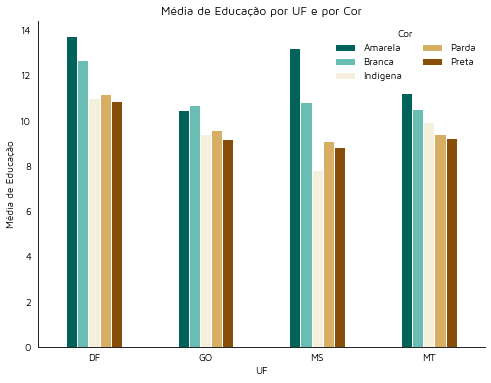

In [71]:
## vendo a média de educação por UF
##objeto gráfico
labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## começando a criar o 1º gráfico
ax1 = medias_educ.plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), figsize = (8,6))

## alternado a legenda
ax1.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 2, frameon = False)
plt.setp(ax1.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax1.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(labels = ['DF','GO','MS','MT'],
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Média de Educação por UF e por Cor", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("UF", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Média de Educação", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

# plt.savefig("media_educ_uf_cor.png", dpi = 300)
plt.show()

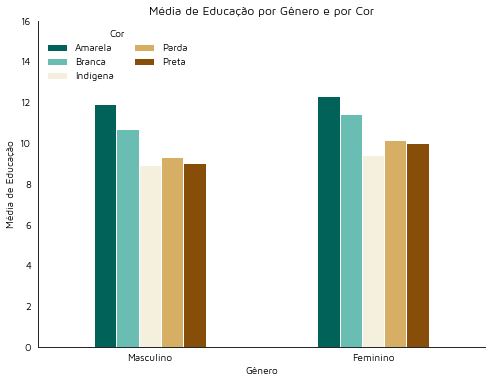

feminino     0     1
cor                 
amarela  11.90 12.30
branca   10.66 11.41
indigena  8.93  9.41
parda     9.31 10.13
preta     9.02 10.02

feminino     0     1
cor                 
amarela  12.00 12.00
branca   12.00 12.00
indigena  9.00 10.00
parda    10.00 12.00
preta    10.00 12.00

In [72]:
## vendo a média de educação por cor
medias_educ = df.groupby(['feminino','cor'])['educ'].mean().unstack()

##objeto gráfico
labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## começando a criar o 1º gráfico
ax1 = medias_educ.plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), figsize = (8,6))

## alternado a legenda
ax1.legend(title = 'Cor', labels = labels_legenda, loc='upper left', ncol = 2, frameon = False)
plt.setp(ax1.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax1.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
ax1.set_xticks([0,1])
ax1.set_xticklabels(labels = ['Masculino','Feminino'], rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
ax1.set_ylim(0,16)
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Média de Educação por Gênero e por Cor", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("Gênero", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Média de Educação", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

# plt.savefig("media_educ_generoo_cor.png", dpi = 300)
plt.show()

display(df.groupby(['cor','feminino'])['educ'].mean().unstack())
display(df.groupby(['cor','feminino'])['educ'].median().unstack())

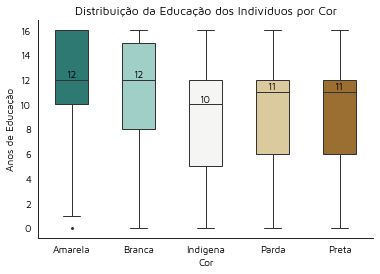

cor
amarela    12.11
branca     11.06
indigena    9.19
parda       9.73
preta       9.50
Name: educ, dtype: float64

cor
amarela    12.00
branca     12.00
indigena   10.00
parda      11.00
preta      11.00
Name: educ, dtype: float64

In [73]:
## vendo a distribuicao de educação por cores
# criando o objeto gráfico
ax1 = sns.boxplot(x='cor',y='educ', data=df, palette="BrBG_r", fliersize = 1, width = 0.5, linewidth = 1)

labels_eixo_x = ['Amarela','Branca','Indígena', 'Parda','Preta']

## alterando as categorias do eixo x
ax1.set_xticks([0,1,2,3,4])
ax1.set_xticklabels(labels = labels_eixo_x, rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Distribuição da Educação dos Indivíduos por Cor", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("Cor", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Anos de Educação", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

## para plotar as medianas
for xtick in ax1.get_xticks():
    ax1.text(xtick, medianas_educ[xtick] + 0.2, medianas_educ[xtick], 
            horizontalalignment='center',size=10 ,color='k', fontname = 'Maven Pro')

## mostrando o plot
# plt.savefig("dist_educacao_cor.png", dpi = 300)
plt.show()
display(df.groupby('cor')['educ'].mean())
display(df.groupby('cor')['educ'].median())

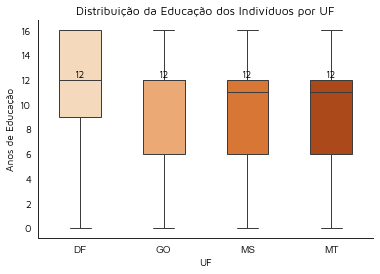

UF
DF   11.69
GO    9.93
MS    9.83
MT    9.75
Name: educ, dtype: float64

UF
DF   12.00
GO   12.00
MS   11.00
MT   11.00
Name: educ, dtype: float64

In [74]:
## vendo a distribuicao de educação por UF
# criando o objeto gráfico
ax1 = sns.boxplot(x='UF',y='educ', data=df, palette="Oranges", fliersize = 1, width = 0.5, linewidth = 1, order = ['DF','GO','MS','MT'])

labels_eixox = ['Amarela','Branca','Indígena', 'Parda','Preta']

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Distribuição da Educação dos Indivíduos por UF", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("UF", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Anos de Educação", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

## para plotar as medianas
for xtick in ax1.get_xticks():
    ax1.text(xtick, df18.groupby('UF')['educ'].median().astype('int')[xtick] + 0.2, df18.groupby('UF')['educ'].median().astype('int')[xtick], 
            horizontalalignment='center',size=10 ,color='k', fontname = 'Maven Pro')

## mostrando o plot
# plt.savefig("dist_educacao_uf.png", dpi = 300)
plt.show()

## apesar de ter uma média superior, a medianna do DF é menor que as demais, indicando uma concentração no que tange ao número de indivíduos bem escolarizados
display(df.groupby('UF')['educ'].mean())
display(df.groupby('UF')['educ'].median())

**Rendimento habitual dos trabalhos principais**

In [75]:
### o que fazer com os rendimentos e educ ausentes?
## dropar
#df.dropna(subset=['renda_hab_domiciliar_pc','educ','grau_educ'], axis = 0, inplace=True)
#dfp.dropna(subset=['renda_hab_domiciliar_pc','educ','grau_educ'], axis = 0, inplace=True)
#df18.dropna(subset=['renda_hab_domiciliar_pc','educ','grau_educ'], axis = 0, inplace=True)

## substituir por 0
#df[['renda_hab_domiciliar_pc','educ','grau_educ']].replace([np.nan], [0], inplace=True)
#dfp[['renda_hab_domiciliar_pc','educ','grau_educ']].replace([np.nan], [0], inplace=True)
#df18[['renda_hab_domiciliar_pc','educ','grau_educ']].replace([np.nan], [0], inplace=True)

In [76]:
##  contagem de indivíduos por faixa de S.M. habitual per capita (sal_minimo)
## criando o dataframe
g = df.groupby(['cor', 'sal_minimo']).size().reset_index().pivot(columns='cor', index='sal_minimo', values=0)

# modificando as colunas para permitir a soma de cada categoria
g.columns = g.columns.astype(str)
g['total'] = g.sum(axis=1)

# reordenando o index
labels_eixo_x = ["1/4 SM","1/4 a 1/2 SM","1/2 a 1 SM","1 a 2 SM","2 a 5 SM",'5 a 10 SM','+10 SM']
list_ordering = ["1/4_SM","1/2_SM","1_SM","2_SM","5_SM",'10_SM','+10_SM']
g = g.reindex(list_ordering) 

# criando um g com valores percentuais
g1 = g[['amarela','branca','indigena','parda','preta']].div(g.total, axis = 0)

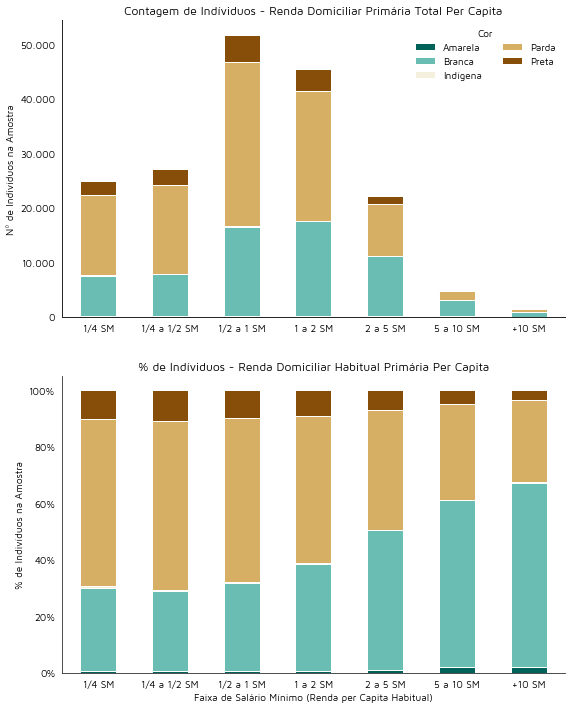

cor         amarela  branca  indigena  parda  preta   total
sal_minimo                                                 
1/4_SM          137    7397       177  14722   2527   24960
1/2_SM          153    7667       153  16225   2932   27130
1_SM            270   16240       194  30096   5028   51828
2_SM            267   17269       139  23813   4062   45550
5_SM            222   11008        54   9449   1514   22247
10_SM            98    2953        10   1688    249    4998
+10_SM           29     966         5    426     51    1477
Total          1176   63500       732  96419  16363  178190

In [77]:
#objeto gráfico
fig, ax = plt.subplots(nrows = 2, figsize = (9,12))

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## começando a criar o 1º gráfico
ax1 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0])

## alternado a legenda
ax1.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 2, frameon = False)
plt.setp(ax1.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax1.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
ax1.set_xticks([0,1,2,3,4,5,6])
ax1.set_xticklabels(labels = labels_eixo_x,
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Contagem de Indíviduos - Renda Domiciliar Primária Total Per Capita", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

########################################
## começando a criar o 2º gráfico
ax2 = g1[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1])
ax2.legend([],[], frameon=False)

## alterando as categorias do eixo x
ax2.set_xticks([0,1,2,3,4,5,6])
ax2.set_xticklabels(labels = labels_eixo_x,
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in ax2.get_yticks()]
ax2.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax2.set_title("% de Indíviduos - Renda Domiciliar Habitual Primária Per Capita", color = 'k',fontname = 'Maven Pro')
ax2.set_xlabel("Faixa de Salário Mínimo (Renda per Capita Habitual)", color = 'k',fontname = 'Maven Pro')
ax2.set_ylabel("% de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

## mostrando o plot
#plt.savefig("amostra_rendadomiciliarpc_cor.png", dpi = 300)
plt.show()

display(g.append(g.sum().rename('Total')))
#g.append(g.sum().rename('Total')).to_clipboard()

In [78]:
## calculando a média de rendimento efetivos totais por cor e educ
g = df.groupby(['grau_educ','cor'])['renda_hab_prin'].mean().unstack()

# reordenando o index
list_ordering = ["sem_instrucao","fund_incompleto","fund_completo","medio_incompleto","medio_completo",'superior_incompleto','superior_completo']
g = g.reindex(list_ordering)
# g.to_clipboard()
g

cor                  amarela  branca  indigena   parda   preta
grau_educ                                                     
sem_instrucao        1550.00 1282.71   1227.91 1211.50 1210.44
fund_incompleto      1461.67 1683.02   1162.58 1437.63 1413.14
fund_completo        1480.24 1941.23   1509.88 1519.76 1451.65
medio_incompleto     1516.42 1752.39   1175.52 1419.85 1425.68
medio_completo       2362.66 2145.01   1493.85 1757.54 1709.51
superior_incompleto  2543.82 2129.58   2715.26 1830.17 1835.79
superior_completo    6343.72 5198.11   5006.41 4221.75 3968.40

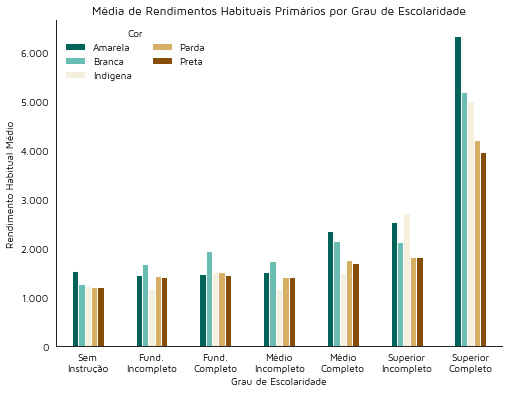

grau_educ
fund_completo         1706.33
fund_incompleto       1570.81
medio_completo        2000.61
medio_incompleto      1534.81
sem_instrucao         1332.81
superior_completo     4952.36
superior_incompleto   2092.54
Name: renda_hab_tot, dtype: float64

In [79]:
labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']
labels_eixo_x = ["Sem\nInstrução","Fund.\nIncompleto","Fund.\nCompleto","Médio\nIncompleto","Médio\nCompleto", "Superior\nIncompleto", "Superior\nCompleto"]

## começando a criar o 1º gráfico
ax1 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), figsize = (8,6))

## alternado a legenda
ax1.legend(title = 'Cor', labels = labels_legenda, loc='upper left',ncol = 2, frameon = False)
plt.setp(ax1.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax1.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
ax1.set_xticks([0,1,2,3,4,5,6])
ax1.set_xticklabels(labels = labels_eixo_x,
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Média de Rendimentos Habituais Primários por Grau de Escolaridade", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("Grau de Escolaridade", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Rendimento Habitual Médio", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

# plt.savefig("media_rendahabprin_educ_cor.png", dpi = 300)
plt.show()

## brancos tem rendimentos rotineiramente maior do que o de pretos, pardos e indígenas, especialmente entre aqueles que possuem alguma instrução
# vale ressaltar a renda de amarelos com médio e superior completo
display(df18.groupby('grau_educ')['renda_hab_tot'].mean())

In [80]:
## rendimento efetivos totais média e mediana de cada grupo (separar por UF também)
medias_renda = df.groupby(['UF','cor'])['renda_hab_prin'].mean().unstack()
medianas_renda = df.groupby('cor')['renda_hab_prin'].median().astype('int')
print("Média:")
display(medias_renda)

print("\nMediana:")
display(medianas_renda)

Média:


cor  amarela  branca  indigena   parda   preta
UF                                            
DF   7476.86 4686.55   3381.12 2941.41 2507.46
GO   1842.71 2405.59   1977.11 1765.63 1684.38
MS   3174.92 2421.47   1388.83 1745.72 1765.09
MT   2436.16 2723.02   1787.19 1860.06 1817.03


Mediana:


cor
amarela     2000
branca      1728
indigena    1200
parda       1400
preta       1400
Name: renda_hab_prin, dtype: int64

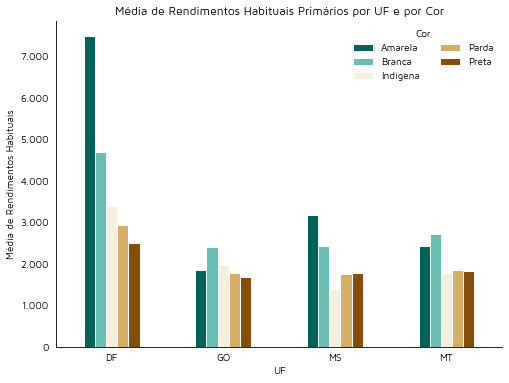

In [81]:
## vendo a média de renda efetiva total por UF
##objeto gráfico
labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## começando a criar o 1º gráfico
ax1 = medias_renda.plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), figsize = (8,6))

## alternado a legenda
ax1.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 2, frameon = False)
plt.setp(ax1.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax1.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(labels = ['DF','GO','MS','MT'],
    rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Média de Rendimentos Habituais Primários por UF e por Cor", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("UF", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Média de Rendimentos Habituais", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

# plt.savefig("media_rendahabprin_uf_cor.png", dpi = 300)
plt.show()
## bizarro: DF (setor público) e MS e MT + soja; lembrar que em 2018q1 a renda efetiva é menor em virtude do maior desemprego pós-festas de fim de ano

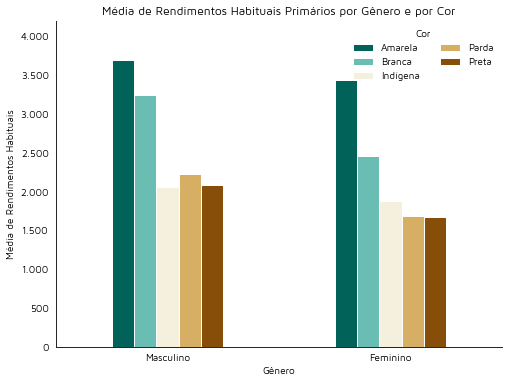

feminino       0       1
cor                     
amarela  3690.70 3438.83
branca   3240.05 2455.84
indigena 2056.72 1872.35
parda    2223.02 1687.74
preta    2081.18 1673.70

feminino       0       1
cor                     
amarela  2000.00 1500.00
branca   2000.00 1500.00
indigena 1400.00 1100.00
parda    1500.00 1129.50
preta    1500.00 1128.50

In [82]:
## vendo as médias de renda por cor
medias_renda = df.groupby(['feminino','cor'])['renda_hab_prin'].mean().unstack()

##objeto gráfico
labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## começando a criar o 1º gráfico
ax1 = medias_renda.plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), figsize = (8,6))

## alternado a legenda
ax1.legend(title = 'Cor', labels = labels_legenda, loc='upper right', ncol = 2, frameon = False)
plt.setp(ax1.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax1.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
ax1.set_xticks([0,1])
ax1.set_xticklabels(labels = ['Masculino','Feminino'], rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
ax1.set_ylim(0,4200)
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Média de Rendimentos Habituais Primários por Gênero e por Cor", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("Gênero", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Média de Rendimentos Habituais", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

#plt.savefig("media_renda_genero_cor.png", dpi = 300)
plt.show()

display(df.groupby(['cor','feminino'])['renda_hab_prin'].mean().unstack())
display(df.groupby(['cor','feminino'])['renda_hab_prin'].median().unstack())

count    mean     std   min     25%     50%     75%       max
cor                                                                      
amarela    814.00 3576.21 4331.39 99.00 1055.00 2000.00 4500.00  35000.00
branca   43698.00 2890.98 4242.64 20.00 1007.00 1728.50 3000.00 229000.00
indigena   440.00 1975.43 2387.36 70.00  954.00 1200.00 2000.00  17000.00
parda    63877.00 2000.84 2908.34  7.00  954.00 1400.00 2000.00 250000.00
preta    11273.00 1920.84 2058.91 20.00  954.00 1400.00 2000.00  50000.00

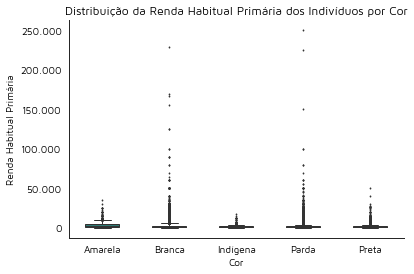

In [83]:
## distribuição dos rendimentos efetivos totais (boxplot/violinplot)
## vendo a distribuicao de renda por cores
# criando o objeto gráfico
ax1 = sns.boxplot(x='cor',y='renda_hab_prin', data=df, palette="BrBG_r", fliersize = 1, width = 0.5, linewidth = 1)

labels_eixo_x = ['Amarela','Branca','Indígena', 'Parda','Preta']

## alterando as categorias do eixo x
ax1.set_xticks([0,1,2,3,4])
ax1.set_xticklabels(labels = labels_eixo_x, rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
# colocando um limite pra não ficar muito ridiculo
# ax1.set_ylim(0,100000)
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Distribuição da Renda Habitual Primária dos Indivíduos por Cor", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("Cor", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Renda Habitual Primária", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

## mostrando o plot
#plt.savefig("dist_renda_cor.png", dpi = 300)
display(df.groupby('cor')['renda_hab_prin'].describe())
plt.show()

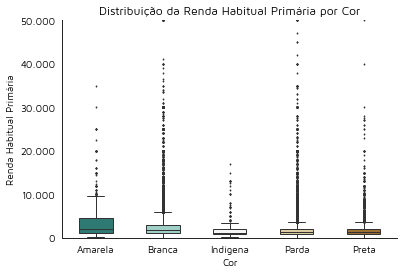

In [84]:
## mostrando apenas com 50000 de limite
# criando o objeto gráfico
ax1 = sns.boxplot(x='cor',y='renda_hab_prin', data=df, palette="BrBG_r", fliersize = 1, width = 0.5, linewidth = 1)

labels_eixo_x = ['Amarela','Branca','Indígena', 'Parda','Preta']

## alterando as categorias do eixo x
ax1.set_xticks([0,1,2,3,4])
ax1.set_xticklabels(labels = labels_eixo_x, rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
# colocando um limite pra não ficar muito ridiculo
ax1.set_ylim(0,50000)
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Distribuição da Renda Habitual Primária por Cor", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("Cor", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Renda Habitual Primária", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

## mostrando o plot
#plt.savefig("dist_renda50000_cor.png", dpi = 300)
plt.show()

In [85]:
## dado que o último gráfico É RÍDICULO DE ABSURDO, investigando mais
print("Distribuição de rendas habituais primárias - todas as cores")
df['renda_hab_prin'].describe()

Distribuição de rendas habituais primárias - todas as cores


count   120110.00
mean      2328.24
std       3435.30
min          7.00
25%       1000.00
50%       1500.00
75%       2500.00
max     250000.00
Name: renda_hab_prin, dtype: float64

In [86]:
print("Distribuição de rendas habituais - por cor:")
df.groupby("cor").renda_hab_prin.describe()

Distribuição de rendas habituais - por cor:


count    mean     std   min     25%     50%     75%       max
cor                                                                      
amarela    814.00 3576.21 4331.39 99.00 1055.00 2000.00 4500.00  35000.00
branca   43698.00 2890.98 4242.64 20.00 1007.00 1728.50 3000.00 229000.00
indigena   440.00 1975.43 2387.36 70.00  954.00 1200.00 2000.00  17000.00
parda    63877.00 2000.84 2908.34  7.00  954.00 1400.00 2000.00 250000.00
preta    11273.00 1920.84 2058.91 20.00  954.00 1400.00 2000.00  50000.00

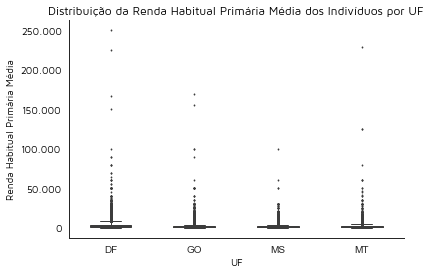

In [87]:
## vendo a distribuicao de renda por UF
# criando o objeto gráfico
ax1 = sns.boxplot(x='UF',y='renda_hab_prin', data=df, palette="Oranges", fliersize = 1, width = 0.5, linewidth = 1, order = ['DF','GO','MS','MT'])

## alterando a formatação do eixo y
# colocando um limite pra não ficar muito ridiculo
#ax1.set_ylim(0,50000)
numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in ax1.get_yticks()]
ax1.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Distribuição da Renda Habitual Primária Média dos Indivíduos por UF", color = 'k',fontname = 'Maven Pro')
ax1.set_xlabel("UF", color = 'k',fontname = 'Maven Pro')
ax1.set_ylabel("Renda Habitual Primária Média", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1)

## mostrando o plot
plt.savefig("dist_rendahabprin_uf.png", dpi = 300)
plt.show()

In [88]:
## dado que o último gráfico É RÍDICULO DE ABSURDO, investigando mais
print("Distribuição de rendas habituais - por UF:")
df18.groupby("UF").renda_hab_prin.describe()

Distribuição de rendas habituais - por UF:


count    mean     std   min     25%     50%     75%       max
UF                                                                
DF 4409.00 3681.43 6957.18 20.00 1100.00 1800.00 4000.00 250000.00
GO 8073.00 1981.26 2301.65 30.00  954.00 1400.00 2000.00  50000.00
MS 5248.00 2073.36 2401.16 20.00 1000.00 1500.00 2200.00  60000.00
MT 5963.00 2272.63 4486.04 30.00 1000.00 1500.00 2500.00 229000.00

** Por posição de ocupação** (publico/privado, formal/informal)

Para essa análise, consideraremos NaN como desocupado/fora_ft

In [89]:
## substituindo os NaNs
df['pos_ocupacao'] = df['pos_ocupacao'].replace([np.NaN],['desocupado'])
df['pos_ocupacao_agg'] = df['pos_ocupacao_agg'].replace([np.NaN],['desocupado'])

In [90]:
##  contagem de indivíduos por posicao de ocupacao
## criando o dataframe
g = df.groupby(['cor', 'pos_ocupacao_agg']).size().reset_index().pivot(columns='cor', index='pos_ocupacao_agg', values=0)

# modificando as colunas para permitir a soma de cada categoria
g.columns = g.columns.astype(str)
g['total'] = g.sum(axis=1)

# criando um g com valores percentuais
g1 = g[['amarela','branca','indigena','parda','preta']].div(g.total, axis = 0)

In [91]:
##  contagem de indivíduos por posicao de ocupacao (desagregado)
## criando o dataframe
g2 = df.groupby(['cor', 'pos_ocupacao']).size().reset_index().pivot(columns='cor', index='pos_ocupacao', values=0)

# modificando as colunas para permitir a soma de cada categoria
g2.columns = g2.columns.astype(str)
g2['total'] = g2.sum(axis=1)

# criando um g com valores percentuais
g3 = g2[['amarela','branca','indigena','parda','preta']].div(g2.total, axis = 0)

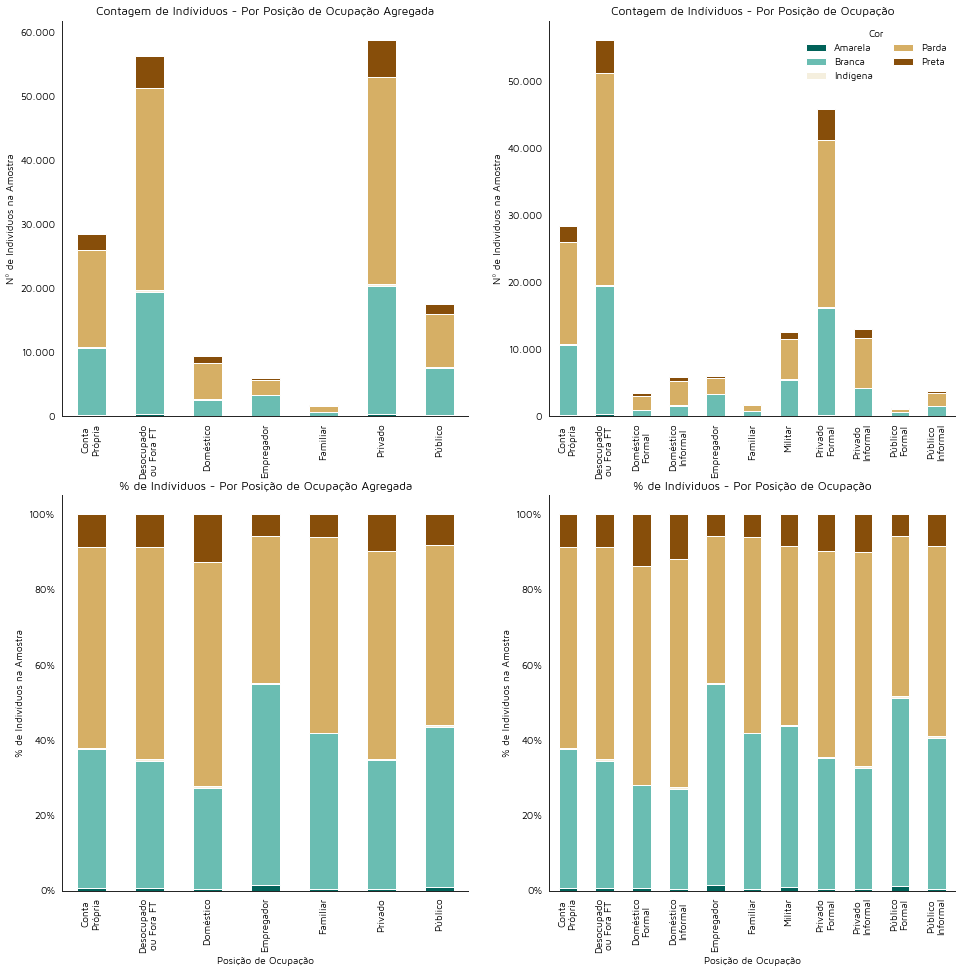

cor               amarela  branca  indigena  parda  preta   total
pos_ocupacao_agg                                                 
conta_propria         213   10473       101  15222   2467   28476
desocupado            351   19025       292  31569   4978   56215
domestico              45    2541        47   5635   1195    9463
empregador             95    3226         9   2370    346    6046
familiar               10     726         0    917    108    1761
privado               314   20054       220  32354   5822   58764
publico               148    7455        63   8352   1447   17465
Total                1176   63500       732  96419  16363  178190

cor                 amarela  branca  indigena  parda  preta   total
pos_ocupacao                                                       
conta_propria           213   10473       101  15222   2467   28476
desocupado              351   19025       292  31569   4978   56215
domestico_formal         21     966         9   2047    490    3533
domestico_informal       24    1575        38   3588    705    5930
empregador1              95    3226         9   2370    346    6046
familiar                 10     726         0    917    108    1761
militar                 112    5365        42   5952   1063   12534
privado_formal          245   15898       169  24979   4516   45807
privado_informal         69    4156        51   7375   1306   12957
publico_formal           16     583         7    497     67    1170
publico_informal         20    1507        14   1903    317    3761
Total                  1176   63500       732  96419  16363  178190

In [92]:
# objeto gráfico
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16,16))

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## criando os objetos gráficos
ax11 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0,0])
ax21 = g1[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1,0])
ax12 = g2[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0,1])
ax22 = g3[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1,1])

## alternado a legenda
ax12.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 2, frameon = False)
plt.setp(ax12.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax12.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

for graph in [ax11, ax21, ax22]:
    graph.legend([],[], frameon=False)

## alterando as categorias do eixo x
# posicoes agregadas
labels_agg = ['Conta\nPrópria','Desocupado\nou Fora FT','Doméstico','Empregador','Familiar','Privado','Público']
for graph in [ax11,ax21]:
    graph.set_xticks([0,1,2,3,4,5,6])
    graph.set_xticklabels(labels = labels_agg, rotation = 90, color = 'k', fontname = 'Maven Pro')

# posicoes desagregadas
labels = ['Conta\nPrópria','Desocupado\nou Fora FT','Doméstico\nFormal','Doméstico\nInformal','Empregador','Familiar','Militar','Privado\nFormal','Privado\nInformal','Público\nFormal', 'Público\nInformal']
for graph in [ax12, ax22]:
    graph.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    graph.set_xticklabels(labels = labels, rotation = 90, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
# contagem absoluta
for graph in [ax11, ax12]:
    numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

# percentual
for graph in [ax21, ax22]:
    numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax11.set_title("Contagem de Indíviduos - Por Posição de Ocupação Agregada", color = 'k',fontname = 'Maven Pro')
ax11.set_xlabel("", color = 'k',fontname = 'Maven Pro')
ax11.set_ylabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

ax21.set_title("% de Indíviduos - Por Posição de Ocupação Agregada", color = 'k',fontname = 'Maven Pro')
ax21.set_xlabel("Posição de Ocupação", color = 'k',fontname = 'Maven Pro')
ax21.set_ylabel("% de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

ax12.set_title("Contagem de Indíviduos - Por Posição de Ocupação", color = 'k',fontname = 'Maven Pro')
ax12.set_xlabel("", color = 'k',fontname = 'Maven Pro')
ax12.set_ylabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

ax22.set_title("% de Indíviduos - Por Posição de Ocupação", color = 'k',fontname = 'Maven Pro')
ax22.set_xlabel("Posição de Ocupação", color = 'k',fontname = 'Maven Pro')
ax22.set_ylabel("% de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for graph in [ax11, ax21, ax12, ax22]:
    for axis in ['top','bottom','left','right']:
        graph.spines[axis].set_linewidth(1)

## mostrando o plot
#plt.savefig("pos_ocupacao_cor.png", dpi = 300)
plt.show()

## Informais: conta própria + doméstico informal + privado informal + público informal
display(g.append(g.sum().rename('Total')))
display(g2.append(g2.sum().rename('Total')))
# pretos e pardos sobrerepresentados em funções domésticas e informais + baixo nível de familiares

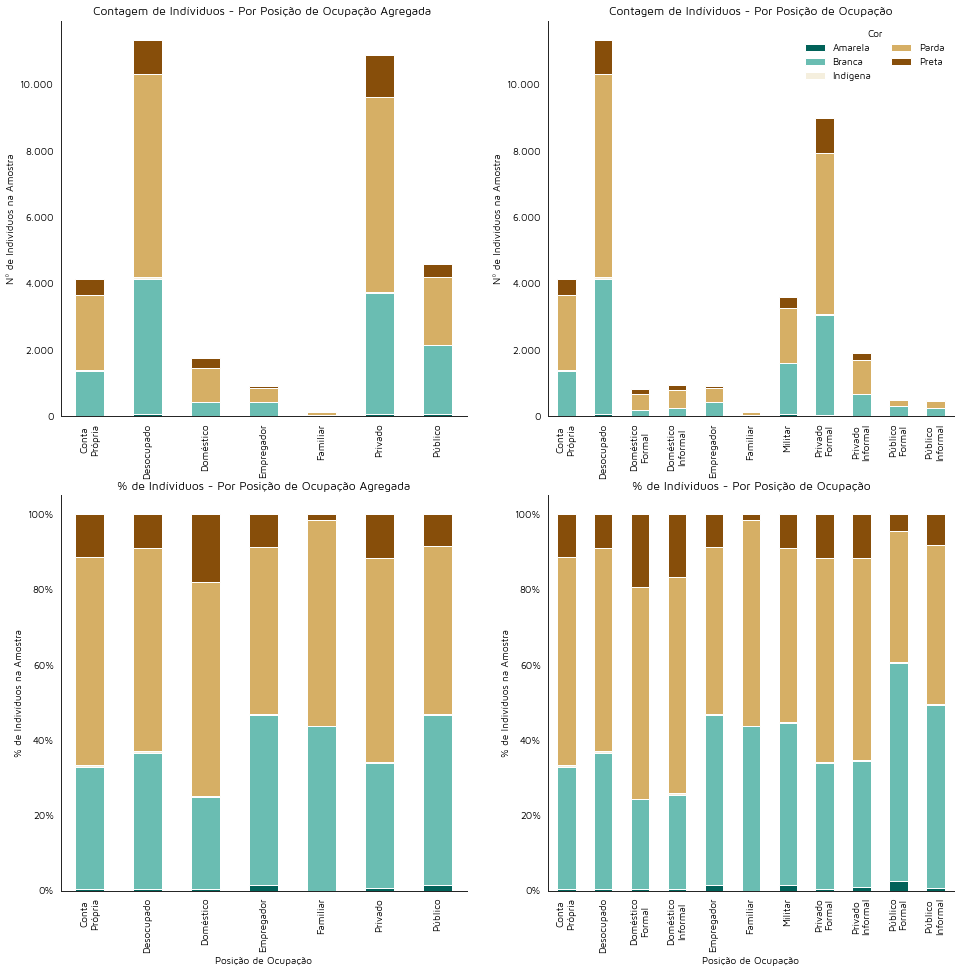

cor               amarela  branca  indigena  parda  preta  total
pos_ocupacao_agg                                                
conta_propria          21    1338        27   2276    475   4137
desocupado             59    4092        53   6112   1032  11348
domestico               6     431         4   1002    315   1758
empregador             13     417         2    409     81    922
familiar                0      53         0     66      2    121
privado                64    3636        34   5887   1264  10885
publico                70    2072        14   2047    384   4587
Total                 233   12039       134  17799   3553  33758

In [93]:
## fazendo a mesma coisa só que para o DF
##  contagem de indivíduos por posicao de ocupacao
## criando o dataframe
g = df.loc[df['UF'] == "DF"].groupby(['cor', 'pos_ocupacao_agg']).size().reset_index().pivot(columns='cor', index='pos_ocupacao_agg', values=0)

# modificando as colunas para permitir a soma de cada categoria
g.columns = g.columns.astype(str)
g['total'] = g.sum(axis=1)

# criando um g com valores percentuais
g1 = g[['amarela','branca','indigena','parda','preta']].div(g.total, axis = 0)

##  contagem de indivíduos por posicao de ocupacao (desagregado)
## criando o dataframe
g2 = df.loc[df['UF'] == "DF"].groupby(['cor', 'pos_ocupacao']).size().reset_index().pivot(columns='cor', index='pos_ocupacao', values=0)

# modificando as colunas para permitir a soma de cada categoria
g2.columns = g2.columns.astype(str)
g2['total'] = g2.sum(axis=1)

# criando um g com valores percentuais
g3 = g2[['amarela','branca','indigena','parda','preta']].div(g2.total, axis = 0)

# objeto gráfico
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16,16))

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## criando os objetos gráficos
ax11 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0,0])
ax21 = g1[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1,0])
ax12 = g2[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0,1])
ax22 = g3[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1,1])

## alternado a legenda
ax12.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 2, frameon = False)
plt.setp(ax12.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax12.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

for graph in [ax11, ax21, ax22]:
    graph.legend([],[], frameon=False)

## alterando as categorias do eixo x
# posicoes agregadas
labels_agg = ['Conta\nPrópria','Desocupado','Doméstico','Empregador','Familiar','Privado','Público']
for graph in [ax11,ax21]:
    graph.set_xticks([0,1,2,3,4,5,6])
    graph.set_xticklabels(labels = labels_agg, rotation = 90, color = 'k', fontname = 'Maven Pro')

# posicoes desagregadas
labels = ['Conta\nPrópria','Desocupado','Doméstico\nFormal','Doméstico\nInformal','Empregador','Familiar','Militar','Privado\nFormal','Privado\nInformal','Público\nFormal', 'Público\nInformal']
for graph in [ax12, ax22]:
    graph.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    graph.set_xticklabels(labels = labels, rotation = 90, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
# contagem absoluta
for graph in [ax11, ax12]:
    numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

# percentual
for graph in [ax21, ax22]:
    numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax11.set_title("Contagem de Indíviduos - Por Posição de Ocupação Agregada ", color = 'k',fontname = 'Maven Pro')
ax11.set_xlabel("", color = 'k',fontname = 'Maven Pro')
ax11.set_ylabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

ax21.set_title("% de Indíviduos - Por Posição de Ocupação Agregada", color = 'k',fontname = 'Maven Pro')
ax21.set_xlabel("Posição de Ocupação", color = 'k',fontname = 'Maven Pro')
ax21.set_ylabel("% de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

ax12.set_title("Contagem de Indíviduos - Por Posição de Ocupação", color = 'k',fontname = 'Maven Pro')
ax12.set_xlabel("", color = 'k',fontname = 'Maven Pro')
ax12.set_ylabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

ax22.set_title("% de Indíviduos - Por Posição de Ocupação", color = 'k',fontname = 'Maven Pro')
ax22.set_xlabel("Posição de Ocupação", color = 'k',fontname = 'Maven Pro')
ax22.set_ylabel("% de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for graph in [ax11, ax21, ax12, ax22]:
    for axis in ['top','bottom','left','right']:
        graph.spines[axis].set_linewidth(1)

## mostrando o plot
# plt.savefig("pos_ocupacao_cor_df.png", dpi = 300)
plt.show()

## Informais: conta própria + doméstico informal + privado informal + público informal
display(g.append(g.sum().rename('Total')))
# esperava mais funcionários públicos, apesar de os 15% representarem mais que os 9% da região como um todo. viés de renda alta?

In [94]:
## calculando a média de rendimento habituais primários por ocupacao_agg e por ocupacao
g = df.loc[df['desocupado'] == 0].groupby(['pos_ocupacao_agg','cor'])['renda_hab_prin'].mean().unstack()
g2 = df.loc[df['desocupado'] == 0].groupby(['pos_ocupacao','cor'])['renda_hab_prin'].mean().unstack()

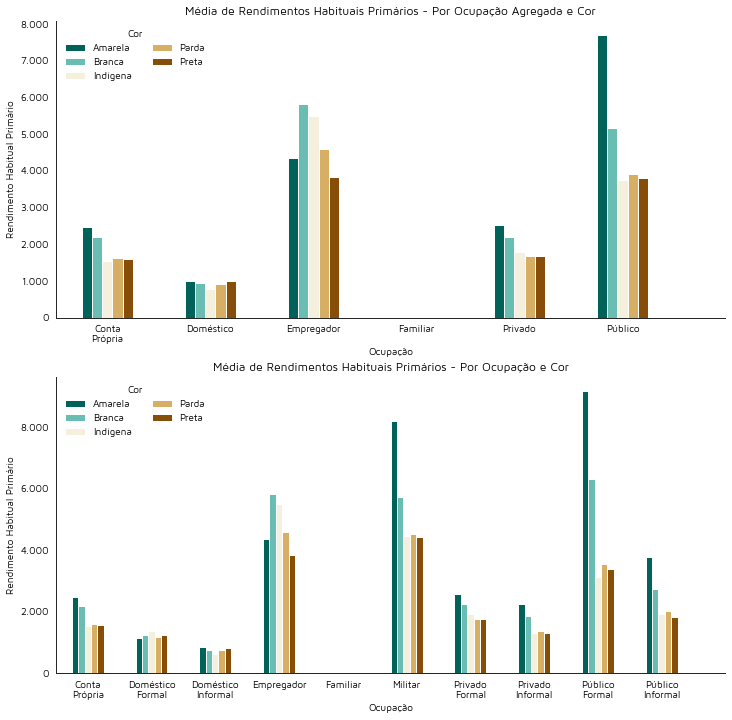

cor                 amarela  branca  indigena   parda   preta
pos_ocupacao                                                 
conta_propria       2469.79 2184.82   1532.86 1618.88 1585.09
domestico_formal    1163.81 1236.30   1370.89 1187.32 1231.16
domestico_informal   849.67  774.82    639.89  765.38  817.48
empregador1         4359.45 5824.77   5500.00 4602.87 3840.21
familiar                nan     nan       nan     nan     nan
militar             8184.99 5728.28   4448.62 4535.84 4432.11
privado_formal      2587.09 2264.98   1923.44 1779.87 1775.72
privado_informal    2253.18 1879.45   1322.55 1362.43 1302.44
publico_formal      9168.75 6302.56   3122.00 3565.89 3378.42
publico_informal    3775.90 2730.19   1929.14 2034.36 1836.91

pos_ocupacao
conta_propria        1830.28
desocupado               nan
domestico_formal     1207.12
domestico_informal    773.65
empregador1          5209.50
familiar                 nan
militar              5072.07
privado_formal       1952.99
privado_informal     1526.16
publico_formal       4992.78
publico_informal     2305.00
Name: renda_hab_prin, dtype: float64

In [95]:
# objeto gráfico
fig, ax = plt.subplots(nrows = 2, figsize = (12,12))

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## criando os objetos gráficos
ax11 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0])
ax12 = g2[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1])

## alternado a legenda
for graph in [ax11, ax12]:
    graph.legend(title = 'Cor', labels = labels_legenda, loc='upper left',ncol = 2, frameon = False)
    plt.setp(graph.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
    plt.setp(graph.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
# posicoes agregadas
labels_agg = ['Conta\nPrópria','Doméstico','Empregador','Familiar','Privado','Público']
ax11.set_xticks([0,1,2,3,4,5,6])
ax11.set_xticklabels(labels = labels_agg, rotation = 0, color = 'k', fontname = 'Maven Pro')

# posicoes desagregadas
labels = ['Conta\nPrópria','Doméstico\nFormal','Doméstico\nInformal','Empregador','Familiar','Militar','Privado\nFormal','Privado\nInformal','Público\nFormal', 'Público\nInformal']
ax12.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax12.set_xticklabels(labels = labels, rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
for graph in [ax11, ax12]:
    numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax11.set_title("Média de Rendimentos Habituais Primários - Por Ocupação Agregada e Cor", color = 'k',fontname = 'Maven Pro')
ax11.set_xlabel("Ocupação", color = 'k',fontname = 'Maven Pro')
ax11.set_ylabel("Rendimento Habitual Primário", color = 'k',fontname = 'Maven Pro')

ax12.set_title("Média de Rendimentos Habituais Primários - Por Ocupação e Cor" , color = 'k',fontname = 'Maven Pro')
ax12.set_xlabel("Ocupação", color = 'k',fontname = 'Maven Pro')
ax12.set_ylabel("Rendimento Habitual Primário", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for graph in [ax11, ax12]:
    for axis in ['top','bottom','left','right']:
        graph.spines[axis].set_linewidth(1)

## mostrando o plot
# plt.savefig("renda_pos_ocupacao_cor.png", dpi = 300)
plt.show()

# em geral, pretos e pardos possuem rendimentos menores independentemente de sua ocupação; familiares não possuem renda habitual primária?
display(g2)
#g2.to_clipboard()
display(df.groupby('pos_ocupacao')['renda_hab_prin'].mean())

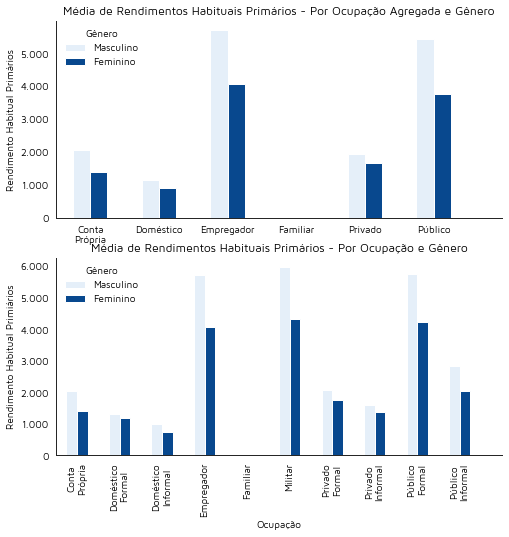

feminino                 0       1
pos_ocupacao                      
conta_propria      2057.67 1399.20
domestico_formal   1318.60 1187.49
domestico_informal 1000.32  755.15
empregador1        5709.89 4070.77
familiar               nan     nan
militar            5972.76 4342.18
privado_formal     2073.12 1746.41
privado_informal   1586.00 1390.80
publico_formal     5758.93 4226.62
publico_informal   2825.71 2054.65

In [96]:
## calculando a média de rendimento habituas primários por ocupacao_agg e por ocupacao por GENERO
g = df.loc[df['desocupado'] == 0].groupby(['pos_ocupacao_agg','feminino'])['renda_hab_prin'].mean().unstack()
g2 = df.loc[df['desocupado'] == 0].groupby(['pos_ocupacao','feminino'])['renda_hab_prin'].mean().unstack()

# objeto gráfico
fig, ax = plt.subplots(nrows = 2, figsize = (8,8))

## criando os objetos gráficos
ax11 = g.plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("Blues", 10)), ax = ax[0])
ax12 = g2.plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("Blues", 10)), ax = ax[1])

## alternado a legenda
for graph in [ax11, ax12]:
    graph.legend(title = 'Gênero', labels = ['Masculino','Feminino'], loc='upper left',ncol = 1, frameon = False)
    plt.setp(graph.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
    plt.setp(graph.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
# posicoes agregadas
labels_agg = ['Conta\nPrópria','Doméstico','Empregador','Familiar','Privado','Público']
ax11.set_xticks([0,1,2,3,4,5,6])
ax11.set_xticklabels(labels = labels_agg, rotation = 0, color = 'k', fontname = 'Maven Pro')

# posicoes desagregadas
labels = ['Conta\nPrópria','Doméstico\nFormal','Doméstico\nInformal','Empregador','Familiar','Militar','Privado\nFormal','Privado\nInformal','Público\nFormal', 'Público\nInformal']
ax12.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax12.set_xticklabels(labels = labels, rotation = 90, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
for graph in [ax11, ax12]:
    numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax11.set_title("Média de Rendimentos Habituais Primários - Por Ocupação Agregada e Gênero", color = 'k',fontname = 'Maven Pro')
ax11.set_xlabel("", color = 'k',fontname = 'Maven Pro')
ax11.set_ylabel("Rendimento Habitual Primários", color = 'k',fontname = 'Maven Pro')

ax12.set_title("Média de Rendimentos Habituais Primários - Por Ocupação e Gênero", color = 'k',fontname = 'Maven Pro')
ax12.set_xlabel("Ocupação", color = 'k',fontname = 'Maven Pro')
ax12.set_ylabel("Rendimento Habitual Primiários", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for graph in [ax11, ax12]:
    for axis in ['top','bottom','left','right']:
        graph.spines[axis].set_linewidth(1)

## mostrando o plot
# plt.savefig("renda_pos_ocupacao_genero.png", dpi = 300)
plt.show()
display(g2)

**Por Setor de Ocupação** (agro, indústria...)

In [97]:
##  contagem de indivíduos por posicao de ocupacao
## criando o dataframe
g = df.groupby(['cor', 'setor_ocupacao']).size().reset_index().pivot(columns='cor', index='setor_ocupacao', values=0)

# modificando as colunas para permitir a soma de cada categoria
g.columns = g.columns.astype(str)
g['total'] = g.sum(axis=1)

# criando um g com valores percentuais
g1 = g[['amarela','branca','indigena','parda','preta']].div(g.total, axis = 0)

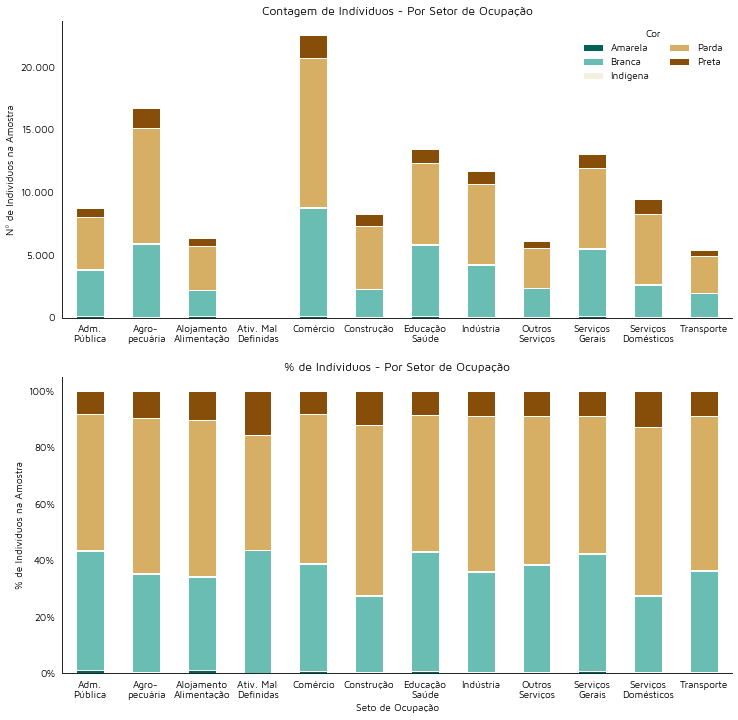

cor                  amarela  branca  indigena  parda  preta  total
setor_ocupacao                                                     
adm_publica               93    3716        33   4215    723   8780
agro                      79    5782        76   9167   1608  16712
aloj_alim                 87    2092        37   3509    667   6392
ativ_mal_definidas         0      14         0     13      5     32
comercio                 162    8593        35  11937   1814  22541
construcao                40    2240        27   4965    998   8270
educ_saude               104    5696        48   6475   1151  13474
industria                 59    4139        64   6416   1045  11723
outros_servicos           27    2312        22   3217    541   6119
servicos                 109    5402        42   6350   1158  13061
servicos_domesticos       45    2555        47   5657   1198   9502
transporte                20    1934         9   2929    477   5369

In [98]:
# objeto gráfico
fig, ax = plt.subplots(nrows = 2, figsize = (12,12))

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## criando os objetos gráficos
ax11 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0])
ax21 = g1[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1])

## alternado a legenda
ax11.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 2, frameon = False)
plt.setp(ax11.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax11.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text
ax21.legend([],[], frameon=False)

## alterando as categorias do eixo x
labels = ['Adm.\nPública','Agro-\npecuária','Alojamento\nAlimentação','Ativ. Mal\nDefinidas','Comércio','Construção','Educação\nSaúde', 'Indústria','Outros\nServiços','Serviços\nGerais','Serviços\nDomésticos','Transporte']
for graph in [ax11,ax21]:
    graph.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    graph.set_xticklabels(labels = labels, rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
# contagem absoluta
for graph in [ax11]:
    numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

# percentual
for graph in [ax21]:
    numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax11.set_title("Contagem de Indíviduos - Por Setor de Ocupação", color = 'k',fontname = 'Maven Pro')
ax11.set_xlabel("", color = 'k',fontname = 'Maven Pro')
ax11.set_ylabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

ax21.set_title("% de Indíviduos - Por Setor de Ocupação", color = 'k',fontname = 'Maven Pro')
ax21.set_xlabel("Seto de Ocupação", color = 'k',fontname = 'Maven Pro')
ax21.set_ylabel("% de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for graph in [ax11, ax21, ax12, ax22]:
    for axis in ['top','bottom','left','right']:
        graph.spines[axis].set_linewidth(1)

## mostrando o plot
# plt.savefig("setor_ocupacao_cor.png", dpi = 300)
plt.show()
display(g)
# em geral, pretos estão sub-representados em funções de adm.pública e educação/saúde, mas tem sua maior proporção em serviços domésticos, atividades mal definidas e construção

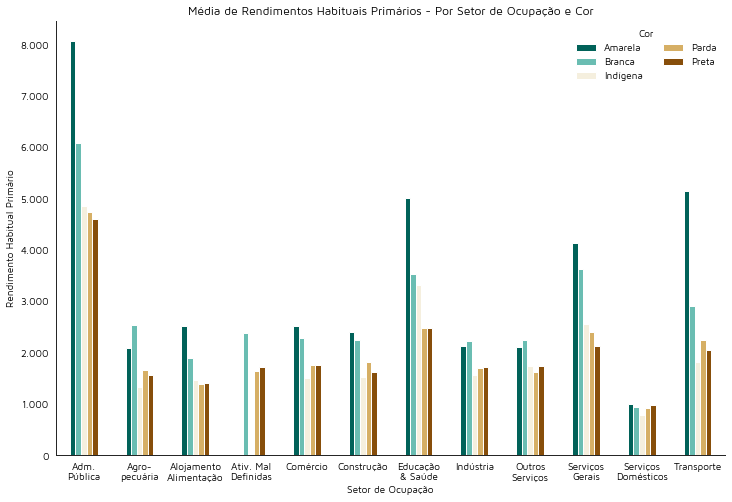

In [99]:
## calculando a média de rendimento habituais primários por setor
g = df.groupby(['setor_ocupacao','cor'])['renda_hab_prin'].mean().unstack()

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## criando os objetos gráficos
ax11 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), figsize = (12,8))

## alternado a legenda
for graph in [ax11]:
    graph.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 2, frameon = False)
    plt.setp(graph.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
    plt.setp(graph.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
labels = ["Adm.\nPública", "Agro-\npecuária",'Alojamento\nAlimentação','Ativ. Mal\nDefinidas','Comércio','Construção','Educação\n& Saúde','Indústria','Outros\nServiços','Serviços\nGerais','Serviços\nDomésticos','Transporte']
for graph in [ax11]:
    graph.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    graph.set_xticklabels(labels = labels, rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
for graph in [ax11]:
    numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax11.set_title("Média de Rendimentos Habituais Primários - Por Setor de Ocupação e Cor", color = 'k',fontname = 'Maven Pro')
ax11.set_xlabel("Setor de Ocupação", color = 'k',fontname = 'Maven Pro')
ax11.set_ylabel("Rendimento Habitual Primário", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
    ax11.spines[axis].set_linewidth(1)

## mostrando o plot
# plt.savefig("renda_setor_ocupacao_cor.png", dpi = 300)
plt.show()
# em geral, pretos e pardos possuem rendimentos menores independentemente de seu setor de ocupação

** Casamento e número de filhos**

In [100]:
df[['casado','num_filhos','num_filhos_05']].describe()

casado  num_filhos  num_filhos_05
count 178200.00   178200.00      178200.00
mean       0.60        0.84           0.18
std        0.49        1.06           0.46
min        0.00        0.00           0.00
25%        0.00        0.00           0.00
50%        1.00        0.00           0.00
75%        1.00        2.00           0.00
max        1.00        9.00           4.00

In [101]:
df.groupby('casado')['cor'].count()

casado
0     71871
1    106319
Name: cor, dtype: int64

In [102]:
## vendo a correlação entre as variáveis
df[['renda_hab_prin','educ','casado','num_filhos','num_filhos_05']].corr()

renda_hab_prin  educ  casado  num_filhos  num_filhos_05
renda_hab_prin            1.00  0.27    0.08        0.05           0.02
educ                      0.27  1.00   -0.12       -0.06           0.06
casado                    0.08 -0.12    1.00        0.46           0.28
num_filhos                0.05 -0.06    0.46        1.00           0.45
num_filhos_05             0.02  0.06    0.28        0.45           1.00

In [103]:
## estatísticas por casado ou não
df.groupby('casado')['renda_hab_prin'].describe()

count    mean     std   min     25%     50%     75%       max
casado                                                                 
0      45680.00 1981.12 3097.91  7.00  954.00 1250.00 2000.00 250000.00
1      74430.00 2541.28 3610.39 10.00 1000.00 1600.00 2700.00 229000.00

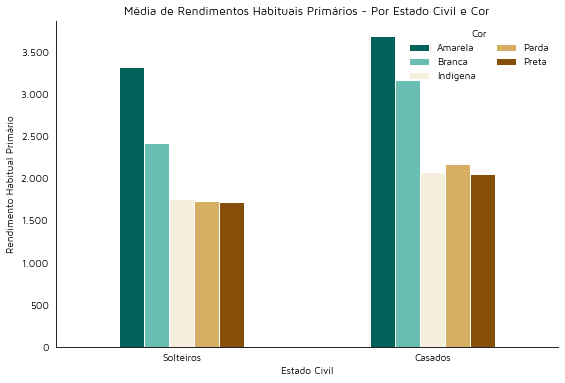

In [104]:
## gráfico
g = df.groupby(['casado','cor'])['renda_hab_prin'].mean().unstack()
labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## criando os objetos gráficos
ax11 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=False, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), figsize = (9,6))

## alternado a legenda
for graph in [ax11]:
    graph.legend(title = 'Cor', labels = labels_legenda, loc='upper right',ncol = 2, frameon = False)
    plt.setp(graph.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
    plt.setp(graph.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text

## alterando as categorias do eixo x
labels = ["Solteiros","Casados"]
for graph in [ax11]:
    graph.set_xticks([0,1])
    graph.set_xticklabels(labels = labels, rotation = 0, color = 'k', fontname = 'Maven Pro')

## alterando a formatação do eixo y
for graph in [ax11]:
    numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax11.set_title("Média de Rendimentos Habituais Primários - Por Estado Civil e Cor", color = 'k',fontname = 'Maven Pro')
ax11.set_xlabel("Estado Civil", color = 'k',fontname = 'Maven Pro')
ax11.set_ylabel("Rendimento Habitual Primário", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for axis in ['top','bottom','left','right']:
    ax11.spines[axis].set_linewidth(1)

## mostrando o plot
#plt.savefig("renda_casamento_cor.png", dpi = 300)
plt.show()

In [105]:
## estatísticas por numero de filhos ou não
df.groupby('num_filhos').count()

Ano  Trimestre     UF  RM_RIDE    UPA  Estrato  V1008  V1014  \
num_filhos                                                                   
0           92363      92363  92363    19223  92363    92363  92363  92363   
1           40248      40248  40248     7836  40248    40248  40248  40248   
2           31812      31812  31812     6263  31812    31812  31812  31812   
3           10402      10402  10402     1932  10402    10402  10402  10402   
4            2498       2498   2498      327   2498     2498   2498   2498   
5             623        623    623       87    623      623    623    623   
6             164        164    164        5    164      164    164    164   
7              43         43     43        2     43       43     43     43   
8              37         37     37       14     37       37     37     37   
9              10         10     10        0     10       10     10     10   

            V1016  V1022  ...  +10_SM  1/2_SM  1/4_SM  10_SM   1_SM   2_SM  \
num_filhos                ...                                                
0           92363  92363  ...   92363   92363   92363  92363  92363  92363   
1           40248  40248  ...   40248   40248   40248  40248  40248  40248   
2           31812  31812  ...   31812   31812   31812  31812  31812  31812   
3           10402  10402  ...   10402   10402   10402  10402  10402  10402   
4            2498   2498  ...    2498    2498    2498   2498   2498   2498   
5             623    623  ...     623     623     623    623    623    623   
6             164    164  ...     164     164     164    164    164    164   
7              43     43  ...      43      43      43     43     43     43   
8              37     37  ...      37      37      37     37     37     37   
9              10     10  ...      10      10      10     10     10     10   

             5_SM  pobreza_bpc  ex_pobreza  pobreza  
num_filhos                                           
0           92363        92363       92363    92363  
1           40248        40248       40248    40248  
2           31812        31812       31812    31812  
3           10402        10402       10402    10402  
4            2498         2498        2498     2498  
5             623          623         623      623  
6             164          164         164      164  
7              43           43          43       43  
8              37           37          37       37  
9              10           10          10       10  

[10 rows x 190 columns]

In [106]:
## vendo por quantis
df['num_filhos'].quantile([0.5,0.75,0.9,0.95,0.96,0.97,0.98,0.99])

0.50   0.00
0.75   2.00
0.90   2.00
0.95   3.00
0.96   3.00
0.97   3.00
0.98   3.00
0.99   4.00
Name: num_filhos, dtype: float64

In [107]:
## estatísticas por numero de filhos ou não
df.groupby('num_filhos')['renda_hab_prin'].describe()

count    mean     std    min     25%     50%     75%       max
num_filhos                                                                  
0          58609.00 2106.53 2725.50   7.00  954.00 1400.00 2000.00 125000.00
1          28579.00 2435.43 3306.81  20.00 1000.00 1500.00 2500.00 229000.00
2          23380.00 2704.73 4267.57  25.00 1000.00 1600.00 2952.50 250000.00
3           7379.00 2557.38 5129.15  30.00 1000.00 1500.00 2500.00 170000.00
4           1639.00 2302.37 5027.32 100.00  954.00 1200.00 2000.00  90000.00
5            378.00 1412.39 1452.27  50.00  937.00 1100.00 1500.00  15000.00
6             91.00 1160.99  711.44  80.00  868.50 1000.00 1500.00   5000.00
7             30.00 1233.13  406.57 400.00  957.00 1200.00 1475.00   2100.00
8             22.00 1011.77  877.76  50.00  325.00  954.00 1200.00   3500.00
9              3.00  409.00  474.04  20.00  145.00  270.00  603.50    937.00

In [108]:
## estatísticas por numero de filhos pequenos
df.groupby(['num_filhos_05','feminino'])['renda_hab_prin'].mean()

num_filhos_05  feminino
0              0          2522.90
               1          1993.06
1              0          2821.94
               1          1956.30
2              0          2908.22
               1          2228.89
3              0          2105.57
               1          2030.75
4              0          2559.00
               1          4000.00
Name: renda_hab_prin, dtype: float64

### Curva de Lorenz (desigualdade) e Parada de Pen (pobreza)

Dados de 2018q1

In [109]:
# vendo os quantis
df['renda_hab_prin'].quantile(q = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.95, 0.99, 0.995, 0.999, 1])

0.10      750.00
0.20      954.00
0.30     1000.00
0.40     1200.00
0.50     1500.00
0.60     1800.00
0.70     2000.00
0.80     3000.00
0.90     4600.00
0.95     7000.00
0.99    15000.00
0.99    20000.00
1.00    30000.00
1.00   250000.00
Name: renda_hab_prin, dtype: float64

In [110]:
## vendo a distribuição em 2018q1
df18renda = df18[['idind','UF','cor','renda_hab_prin','renda_hab_domiciliar','renda_hab_domiciliar_pc','idade']]
df18renda = df18renda.sort_values(by = 'renda_hab_domiciliar_pc')
df18renda = df18renda.reset_index(drop=True)
# df18renda.replace([np.NaN], [0], inplace=True)
df18renda

idind  UF     cor  renda_hab_prin  renda_hab_domiciliar  \
0      652520011920005001  GO  branca             nan                  0.00   
1      652520064719009101  GO   parda             nan                  0.00   
2      652520064719009102  GO   parda             nan                  0.00   
3      652520064877011001  GO   parda             nan                  0.00   
4      652520064877013101  GO  branca             nan                  0.00   
...                   ...  ..     ...             ...                   ...   
26633  652520033450013001  GO  branca        50000.00              50000.00   
26634  653530038867010001  DF   parda       225000.00             225000.00   
26635  653530031521005001  DF   parda       250000.00             250000.00   
26636  651510033047005001  MT  branca       125000.00             250000.00   
26637  651510033047005002  MT  branca       125000.00             250000.00   

       renda_hab_domiciliar_pc  idade  
0                         0.00     21  
1                         0.00     25  
2                         0.00     26  
3                         0.00     34  
4                         0.00     32  
...                        ...    ...  
26633                 50000.00     63  
26634                 56250.00     33  
26635                 83333.33     39  
26636                 83333.33     57  
26637                 83333.33     57  

[26638 rows x 7 columns]

In [111]:
## separando apenas entre branco/amarelo e preto_pardo_indigena
def cor2(s):
    if (s['cor'] == 'branca') or (s['cor'] == 'amarela'):
        return "branca_am"
    elif(s['cor'] == 'preta') or (s['cor'] == 'parda') or (s['cor'] == 'indigena'):
        return "preto_pardo_ind"

df18renda['cor2'] = df18renda.apply(cor2, axis = 1)

In [112]:
## criando a parada de pen
pen = df18renda.groupby('cor2')['renda_hab_prin'].quantile(q = np.linspace(0, 1, num=1001))

# alterando o nome dos indexes e pivotando
pen.index.names=['cor','quantil']
pen = pen.reset_index().pivot(columns='cor',index='quantil')

#corrigindo uma coisinha chata das colunas
pen.columns = pen.columns.droplevel()

In [113]:
## coluna de dominancia
pen['dominancia'] = pen['branca_am'] - pen['preto_pardo_ind']

In [114]:
## vendo o df
## arrumando o formato de exibição
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pen.head(20)

cor      branca_am  preto_pardo_ind  dominancia
quantil                                        
0.0000     47.0000          20.0000     27.0000
0.0010     58.0000          60.0000     -2.0000
0.0020    100.0000         100.0000      0.0000
0.0030    104.0000         100.0000      4.0000
0.0040    150.0000         100.0000     50.0000
0.0050    150.0000         130.0000     20.0000
0.0060    200.0000         150.0000     50.0000
0.0070    200.0000         150.0000     50.0000
0.0080    200.0000         160.0000     40.0000
0.0090    200.0000         200.0000      0.0000
0.0100    200.0000         200.0000      0.0000
0.0110    240.0000         200.0000     40.0000
0.0120    250.0000         200.0000     50.0000
0.0130    250.0000         200.0000     50.0000
0.0140    300.0000         200.0000    100.0000
0.0150    300.0000         200.0000    100.0000
0.0160    300.0000         210.0000     90.0000
0.0170    300.0000         240.0000     60.0000
0.0180    300.0000         250.0000     50.0000
0.0190    300.0000         250.0000     50.0000

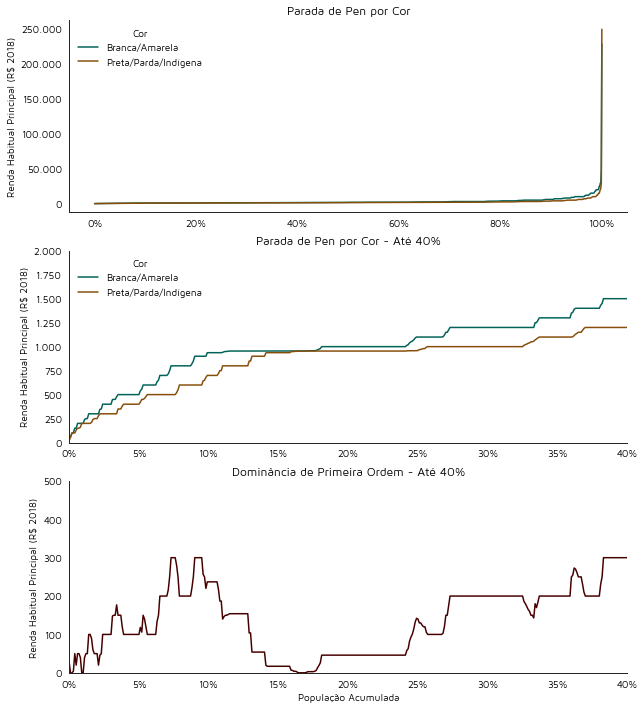

In [115]:
# objeto gráfico
fig, ax = plt.subplots(nrows = 3, figsize = (10,12))

ax1 = pen[['branca_am','preto_pardo_ind']].plot(kind='line', colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0])
ax2 = pen[['branca_am','preto_pardo_ind']].plot(kind='line', colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1])
ax3 = pen[['dominancia']].plot(kind='line', colormap=ListedColormap(sns.color_palette("hot", 10)), ax = ax[2])

labels_legenda = ['Branca/Amarela','Preta/Parda/Indígena']

## alternado a legenda
for graph in [ax1,ax2]:
    graph.legend(title = 'Cor', labels = labels_legenda, loc='upper left', frameon = False)
    plt.setp(graph.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
    plt.setp(graph.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text
ax3.legend([],[], frameon=False)

## alterando as formatações dos eixos
# eixo y
ax2.set_ylim(0,2000)
ax3.set_ylim(0,500)
for graph in [ax1,ax2,ax3]:
    numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

# eixo x
for graph in [ax2,ax3]:
    graph.set_xlim(0,0.4)

for graph in [ax1,ax2,ax3]: 
    numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in graph.get_xticks()]
    graph.set_xticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Parada de Pen por Cor", color = 'k',fontname = 'Maven Pro')
ax2.set_title("Parada de Pen por Cor - Até 40%", color = 'k',fontname = 'Maven Pro')
ax3.set_title("Dominância de Primeira Ordem - Até 40%", color = 'k',fontname = 'Maven Pro')

for graph in [ax1,ax2]:
    graph.set_xlabel("", color = 'k',fontname = 'Maven Pro')
ax3.set_xlabel("População Acumulada", color = 'k',fontname = 'Maven Pro')

for graph in [ax1,ax2,ax3]: 
    graph.set_ylabel("Renda Habitual Principal (R$ 2018)", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for graph in [ax1,ax2,ax3]:
    for axis in ['top','bottom','left','right']:
        graph.spines[axis].set_linewidth(1)
#plt.savefig("ParadaPen.png", dpi = 300)
plt.show()
## brancos/amarelos tem maior renda do que os pretos/pardos/indigenas

In [110]:
## fazendo a curva de lorenz
renda_prin_tot = df18renda['renda_hab_prin'].sum()
df18renda['renda_hab_prin_acum'] = df18renda['renda_hab_prin'].cumsum()/renda_prin_tot
df18renda

idind  UF     cor  renda_hab_prin  renda_hab_domiciliar  \
0      652520011920005001  GO  branca             nan                0.0000   
1      652520064719009101  GO   parda             nan                0.0000   
2      652520064719009102  GO   parda             nan                0.0000   
3      652520064877011001  GO   parda             nan                0.0000   
4      652520064877013101  GO  branca             nan                0.0000   
...                   ...  ..     ...             ...                   ...   
26633  652520033450013001  GO  branca      50000.0000            50000.0000   
26634  653530038867010001  DF   parda     225000.0000           225000.0000   
26635  653530031521005001  DF   parda     250000.0000           250000.0000   
26636  651510033047005001  MT  branca     125000.0000           250000.0000   
26637  651510033047005002  MT  branca     125000.0000           250000.0000   

       renda_hab_domiciliar_pc  idade             cor2  renda_hab_prin_acum  
0                       0.0000     21        branca_am                  nan  
1                       0.0000     25  preto_pardo_ind                  nan  
2                       0.0000     26  preto_pardo_ind                  nan  
3                       0.0000     34  preto_pardo_ind                  nan  
4                       0.0000     32        branca_am                  nan  
...                        ...    ...              ...                  ...  
26633               50000.0000     63        branca_am               0.9872  
26634               56250.0000     33  preto_pardo_ind               0.9912  
26635               83333.3333     39  preto_pardo_ind               0.9956  
26636               83333.3333     57        branca_am               0.9978  
26637               83333.3333     57        branca_am               1.0000  

[26638 rows x 9 columns]

In [111]:
## criando a curva de lorenz
lorenz = df18renda.groupby('cor2')['renda_hab_prin_acum'].quantile(q = np.linspace(0, 1, num=1001))

# alterando o nome dos indexes e pivotando
lorenz.index.names=['cor','quantil']
lorenz = lorenz.reset_index().pivot(columns='cor',index='quantil')

#corrigindo uma coisinha chata das colunas
lorenz.columns = lorenz.columns.droplevel()

In [112]:
## coluna de dominancia
lorenz['dominancia'] = lorenz['branca_am'] - lorenz['preto_pardo_ind']
## coluna de igualdade plena
lorenz['igualdade'] = (lorenz.index*1000 + 1)/1001

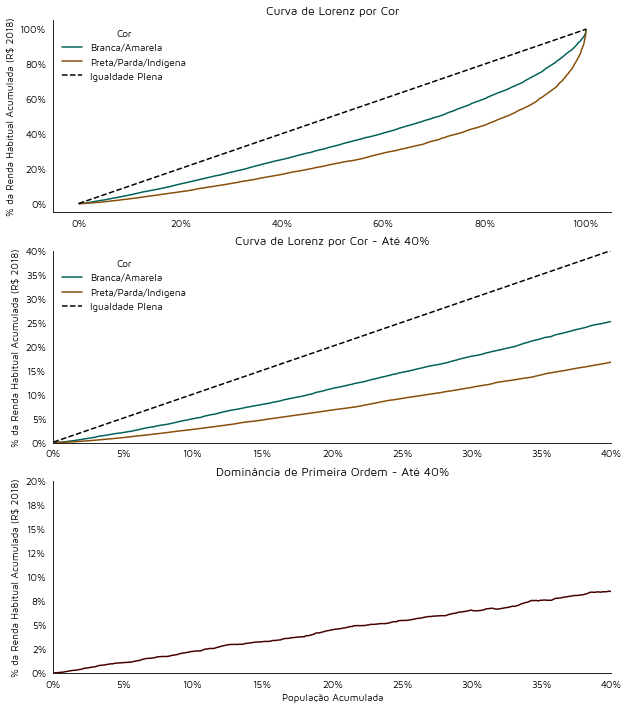

In [113]:
# objeto gráfico
fig, ax = plt.subplots(nrows = 3, figsize = (10,12))

ax1 = lorenz[['branca_am','preto_pardo_ind']].plot(kind='line', colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0])
igualdade1 = lorenz[['igualdade']].plot(kind='line', color = 'k', style = '--', ax = ax[0])
ax2 = lorenz[['branca_am','preto_pardo_ind']].plot(kind='line', colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1])
igualdade2 = lorenz[['igualdade']].plot(kind='line', color = 'k', style = '--', ax = ax[1])
ax3 = lorenz[['dominancia']].plot(kind='line', colormap=ListedColormap(sns.color_palette("hot", 10)), ax = ax[2])

labels_legenda = ['Branca/Amarela','Preta/Parda/Indígena','Igualdade Plena']

## alternado a legenda
for graph in [ax1,ax2]:
    graph.legend(title = 'Cor', labels = labels_legenda, loc='upper left', frameon = False)
    plt.setp(graph.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
    plt.setp(graph.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text
ax3.legend([],[], frameon=False)

## alterando as formatações dos eixos
# eixo y
ax2.set_ylim(0,0.4)
ax3.set_ylim(0,0.2)
for graph in [ax1,ax2,ax3]:
    numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

# eixo x
for graph in [ax2,ax3]:
    graph.set_xlim(0,0.4)

for graph in [ax1,ax2,ax3]: 
    numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in graph.get_xticks()]
    graph.set_xticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax1.set_title("Curva de Lorenz por Cor", color = 'k',fontname = 'Maven Pro')
ax2.set_title("Curva de Lorenz por Cor - Até 40%", color = 'k',fontname = 'Maven Pro')
ax3.set_title("Dominância de Primeira Ordem - Até 40%", color = 'k',fontname = 'Maven Pro')

for graph in [ax1,ax2]:
    graph.set_xlabel("", color = 'k',fontname = 'Maven Pro')
ax3.set_xlabel("População Acumulada", color = 'k',fontname = 'Maven Pro')

for graph in [ax1,ax2,ax3]: 
    graph.set_ylabel("% da Renda Habitual Acumulada (R$ 2018)", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for graph in [ax1,ax2,ax3]:
    for axis in ['top','bottom','left','right']:
        graph.spines[axis].set_linewidth(1)
plt.savefig("Lorenz.png", dpi = 300)
plt.show()
## branco/amarelos tem maior igualdade entre si